In [1]:
from pathlib import Path
import sys 
import pandas as pd
import json

sys.path.append(str(Path.cwd().parent))

from pyspark.sql import SparkSession
import os

# Path to log4j.properties
notebook_dir = Path().resolve()
log4j_path = log4j_path = notebook_dir.parent / "conf" / "log4j.properties"

spark = (
    SparkSession.builder
    .appName("MovieProject")
    .config("spark.driver.extraJavaOptions", f"-Dlog4j.configuration=file:{log4j_path}")
    .config("spark.executor.extraJavaOptions", f"-Dlog4j.configuration=file:{log4j_path}")
    .getOrCreate()
)

spark.sparkContext.setLogLevel("WARN") 

%reload_ext autoreload
%autoreload 2

import scripts.extraction.extractor_tmdb as tmdb
import scripts.transform.clean_data as cln
import scripts.transform.tmdb_schema as ts
import scripts.analysis.kpi_analysis as kpi 
import scripts.visualize.visualizations as viz

Setting default log level to "INFO".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


# Project Summary: Movie Data Analysis

## Methodology

This analysis leverages the TMDB API to fetch detailed metadata for a curated list of high-profile movies (e.g., Avengers series, Star Wars, Jurassic World). The process involves:

1. **Data Collection**: Using `tmdb_client` to retrieve movie details, including credits, for specified movie IDs. Data is compiled into a Pandas DataFrame.

2. **Data Cleaning and Preprocessing** (via `clean_data` module):
   - Extract nested JSON fields (e.g., genres, cast, crew, production countries).
   - Convert columns to appropriate types (numeric, datetime).
   - Replace unrealistic placeholders (e.g., zero budgets/revenues with NaN).
   - Scale budget and revenue to millions USD.
   - Remove duplicates, drop rows with missing critical data (e.g., title, ID), and filter for released movies only.
   - Finalize DataFrame structure with desired column order.

3. **KPI Calculations and Analysis** (via `kpi_analysis` module):
   - Compute profit (revenue - budget) and ROI (revenue / budget, for budgets ≥ $10M).
   - Rank movies by metrics like revenue, profit, ROI, votes, ratings, and popularity.
   - Perform advanced filters (e.g., Sci-Fi/Action movies with Bruce Willis, collaborations like Uma Thurman and Quentin Tarantino).
   - Compare franchise vs. standalone performance (e.g., mean revenue, median ROI).
   - Aggregate franchise success (e.g., total/mean revenue, movie count).
   - Identify top directors by total revenue.

4. **Visualizations** (via `visualizations` module):
   - Scatter plots: Revenue vs. Budget, Popularity vs. Rating.
   - Bar plots: ROI Distribution by Genre, Franchise vs. Standalone Success.
   - Line plot: Yearly Box Office Performance.

Logging is integrated throughout for traceability, and errors (e.g., API fetch failures) are handled with retries.

## Fetch all movies and store in a Database

In [2]:
movie_ids = [0, 299534, 19995, 140607, 299536, 597, 135397, 420818, 24428, 168259, 99861, 284054, 12445, 181808, 330457, 351286, 109445, 321612, 260513]

In [3]:
movies = tmdb.get_all_movies_by_ids(movie_ids)

2026-01-16 16:13:44,109 - INFO - extractor_tmdb - Fetching movie ID: 0
2026-01-16 16:13:44,605 - ERROR - extractor_tmdb - HTTP error on attempt 0: 404 Client Error: Not Found for url: https://api.themoviedb.org/3/movie/0?append_to_response=credits&api_key=d855a01d02babf081991d455eff39348&language=en-US&movie_id=0
2026-01-16 16:13:46,958 - ERROR - extractor_tmdb - HTTP error on attempt 1: 404 Client Error: Not Found for url: https://api.themoviedb.org/3/movie/0?append_to_response=credits&api_key=d855a01d02babf081991d455eff39348&language=en-US&movie_id=0
2026-01-16 16:13:49,394 - ERROR - extractor_tmdb - HTTP error on attempt 2: 404 Client Error: Not Found for url: https://api.themoviedb.org/3/movie/0?append_to_response=credits&api_key=d855a01d02babf081991d455eff39348&language=en-US&movie_id=0
2026-01-16 16:13:51,906 - ERROR - extractor_tmdb - HTTP error on attempt 3: 404 Client Error: Not Found for url: https://api.themoviedb.org/3/movie/0?append_to_response=credits&api_key=d855a01d02ba

## Creating a jsonl of all the records together

In [4]:
output_path = Path("tmdb_raw_movies.jsonl")

with output_path.open("w", encoding="utf-8") as f:
    for movie in movies:
        if movie:
            json.dump(movie, f, ensure_ascii=False)
            f.write("\n")

print(f"Saved {len(movies)} movies to {output_path}")

Saved 18 movies to tmdb_raw_movies.jsonl


### Creation of Dataframe

In [5]:
df = spark.read \
    .option("multiLine", "False") \
    .schema(ts.data_schema) \
    .json(str(output_path))

In [6]:
df.printSchema()

root
 |-- adult: boolean (nullable = true)
 |-- backdrop_path: string (nullable = true)
 |-- belongs_to_collection: struct (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- poster_path: string (nullable = true)
 |    |-- backdrop_path: string (nullable = true)
 |-- budget: long (nullable = true)
 |-- genres: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: integer (nullable = true)
 |    |    |-- name: string (nullable = true)
 |-- homepage: string (nullable = true)
 |-- id: long (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- origin_country: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: double (nullable = true)
 |-- poster_path: string (nullable = true)
 |-- production_companies: array (nullable = tr

In [7]:
df.printSchema()

root
 |-- adult: boolean (nullable = true)
 |-- backdrop_path: string (nullable = true)
 |-- belongs_to_collection: struct (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- poster_path: string (nullable = true)
 |    |-- backdrop_path: string (nullable = true)
 |-- budget: long (nullable = true)
 |-- genres: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: integer (nullable = true)
 |    |    |-- name: string (nullable = true)
 |-- homepage: string (nullable = true)
 |-- id: long (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- origin_country: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: double (nullable = true)
 |-- poster_path: string (nullable = true)
 |-- production_companies: array (nullable = tr

In [8]:
df.columns

['adult',
 'backdrop_path',
 'belongs_to_collection',
 'budget',
 'genres',
 'homepage',
 'id',
 'imdb_id',
 'origin_country',
 'original_language',
 'original_title',
 'overview',
 'popularity',
 'poster_path',
 'production_companies',
 'production_countries',
 'release_date',
 'revenue',
 'runtime',
 'spoken_languages',
 'status',
 'tagline',
 'title',
 'video',
 'vote_average',
 'vote_count',
 'credits']

#### Key Insight

After loading the dataset into a DataFrame for the first time, I noticed that several columns contain nested JSON structures (like genres, spoken languages, collections, and credits). This makes the data harder to analyze directly because the values aren’t in a simple tabular format. So an important early insight is that the dataset will need cleaning and possibly flattening or extracting specific fields before I can run meaningful analyses.

## Drop irrelevant columns

In [9]:
cols_to_drop = ['adult', 'imdb_id', 'original_title', 'video', 'homepage', 	'success', 'status_code', 'status_message']
df = cln.drop_irrelevant_columns(df, cols_to_drop)

In [10]:
df

DataFrame[backdrop_path: string, belongs_to_collection: struct<id:bigint,name:string,poster_path:string,backdrop_path:string>, budget: bigint, genres: array<struct<id:int,name:string>>, id: bigint, origin_country: array<string>, original_language: string, overview: string, popularity: double, poster_path: string, production_companies: array<struct<id:int,logo_path:string,name:string,origin_country:string>>, production_countries: array<struct<iso_3166_1:string,name:string>>, release_date: string, revenue: bigint, runtime: int, spoken_languages: array<struct<english_name:string,iso_639_1:string,name:string>>, status: string, tagline: string, title: string, vote_average: double, vote_count: bigint, credits: struct<cast:array<struct<adult:boolean,gender:int,id:bigint,known_for_department:string,name:string,original_name:string,popularity:double,profile_path:string,cast_id:int,character:string,credit_id:string,order:int>>,crew:array<struct<adult:boolean,gender:int,id:bigint,known_for_depart

In [11]:
df.columns

['backdrop_path',
 'belongs_to_collection',
 'budget',
 'genres',
 'id',
 'origin_country',
 'original_language',
 'overview',
 'popularity',
 'poster_path',
 'production_companies',
 'production_countries',
 'release_date',
 'revenue',
 'runtime',
 'spoken_languages',
 'status',
 'tagline',
 'title',
 'vote_average',
 'vote_count',
 'credits']

#### Insight on Dropping Irrelevant Columns

While preparing the dataset, I realized that many columns were not useful for the type of analysis I want to perform. Columns like status code, status message, original title, IMDb ID, and several others won’t contribute directly to the KPIs I'm trying to calculate. Because of that, I dropped these irrelevant columns so that the dataset only contains the information needed for the analysis. This helps reduce noise in the data, speeds up computations, and makes the overall workflow cleaner and more efficient.

## Evaluate JSON-like columns

In [12]:
categorical_columns = ['belongs_to_collection', 'genres', 'production_countries', 'production_companies', 'spoken_languages', 'origin_country','credits']

In [13]:
df.select(*categorical_columns).show(3, truncate=100, vertical=True)

-RECORD 0---------------------------------------------------------------------------------------------------------------------
 belongs_to_collection | {86311, The Avengers Collection, /yFSIUVTCvgYrpalUktulvk3Gi5Y.jpg, /zuW6fOiusv4X9nnW3paHGfXcSll.jpg} 
 genres                | [{12, Adventure}, {878, Science Fiction}, {28, Action}]                                              
 production_countries  | [{US, United States of America}]                                                                     
 production_companies  | [{420, /hUzeosd33nzE5MCNsZxCGEKTXaQ.png, Marvel Studios, US}]                                        
 spoken_languages      | [{English, en, English}, {Japanese, ja, 日本語}, {Xhosa, xh, }]                                      
 origin_country        | [US]                                                                                                 
 credits               | {[{false, 2, 3223, Acting, Robert Downey Jr., Robert Downey Jr., 9.9269, /5qHNjhtjMD4YWH3

## Extracting and cleaning json columns

In [14]:
df = cln.clean_movie_data(df)

In [15]:
df.limit(10).toPandas()

,backdrop_path,belongs_to_collection,budget,genres,id,origin_country,original_language,overview,popularity,poster_path,...,spoken_languages,status,tagline,title,vote_average,vote_count,cast,cast_size,director,crew_size
0,/7RyHsO4yDXtBv1zUU3mTpHeQ0d5.jpg,The Avengers Collection,356000000.0,Adventure|Science Fiction|Action,299534.0,US,en,After the devastating events of Avengers: Infi...,19.2389,/bR8ISy1O9XQxqiy0fQFw2BX72RQ.jpg,...,English|Japanese|Xhosa,Released,Avenge the fallen.,Avengers: Endgame,8.237,27130.0,Robert Downey Jr.|Chris Evans|Mark Ruffalo|Chr...,107,Anthony Russo|Joe Russo,608
1,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,Avatar Collection,237000000.0,Action|Adventure|Fantasy|Science Fiction,19995.0,US,en,"In the 22nd century, a paraplegic Marine is di...",62.8235,/gKY6q7SjCkAU6FqvqWybDYgUKIF.jpg,...,English|Spanish,Released,Enter the world of Pandora.,Avatar,7.600,33252.0,Sam Worthington|Zoe Saldaña|Sigourney Weaver|S...,67,James Cameron,991
2,/k6EOrckWFuz7I4z4wiRwz8zsj4H.jpg,Star Wars Collection,245000000.0,Adventure|Action|Science Fiction,140607.0,US,en,Thirty years after defeating the Galactic Empi...,11.1639,/wqnLdwVXoBjKibFRR5U3y0aDUhs.jpg,...,English,Released,Every generation has a story.,Star Wars: The Force Awakens,7.254,20200.0,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,183,J.J. Abrams,264
3,/mDfJG3LC3Dqb67AZ52x3Z0jU0uB.jpg,The Avengers Collection,300000000.0,Adventure|Action|Science Fiction,299536.0,US,en,As the Avengers and their allies have continue...,28.6259,/7WsyChQLEftFiDOVTGkv3hFpyyt.jpg,...,English|Xhosa,Released,Destiny arrives all the same.,Avengers: Infinity War,8.235,31339.0,Robert Downey Jr.|Chris Evans|Chris Hemsworth|...,69,Joe Russo|Anthony Russo,734
4,/xnHVX37XZEp33hhCbYlQFq7ux1J.jpg,None,200000000.0,Drama|Romance,597.0,US,en,101-year-old Rose DeWitt Bukater tells the sto...,29.4892,/9xjZS2rlVxm8SFx8kPC3aIGCOYQ.jpg,...,English|French|German|Swedish|Italian|Russian,Released,Nothing on earth could come between them.,Titanic,7.903,26666.0,Leonardo DiCaprio|Kate Winslet|Billy Zane|Kath...,116,James Cameron,262
5,/s5QfDFqRO6sjgPtKkjxD0WqXQef.jpg,Jurassic Park Collection,150000000.0,Action|Adventure|Science Fiction|Thriller,135397.0,US,en,Twenty-two years after the events of Jurassic ...,10.5640,/rhr4y79GpxQF9IsfJItRXVaoGs4.jpg,...,English,Released,The park is open.,Jurassic World,6.700,21219.0,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,53,Colin Trevorrow,428
6,/1TUg5pO1VZ4B0Q1amk3OlXvlpXV.jpg,The Lion King (Reboot) Collection,260000000.0,Adventure|Drama|Family|Animation,420818.0,US,en,"Simba idolizes his father, King Mufasa, and ta...",9.8378,/dzBtMocZuJbjLOXvrl4zGYigDzh.jpg,...,English,Released,The king has returned.,The Lion King,7.099,10602.0,Chiwetel Ejiofor|John Oliver|Donald Glover|Jam...,20,Jon Favreau,50
7,/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg,The Avengers Collection,220000000.0,Science Fiction|Action|Adventure,24428.0,US,en,When an unexpected enemy emerges and threatens...,65.2961,/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg,...,English|Hindi|Russian,Released,Some assembly required.,The Avengers,7.906,35098.0,Robert Downey Jr.|Chris Evans|Mark Ruffalo|Chr...,113,Joss Whedon,642
8,/ehzI1mVcnHqB58NqPyQwpMqcVoz.jpg,The Fast and the Furious Collection,190000000.0,Action|Crime|Thriller,168259.0,US,en,Deckard Shaw seeks revenge against Dominic Tor...,10.4370,/ktofZ9Htrjiy0P6LEowsDaxd3Ri.jpg,...,Arabic|English|Spanish|Thai,Released,Vengeance hits home.,Furious 7,7.219,11090.0,Vin Diesel|Paul Walker|Dwayne Johnson|Michelle...,49,James Wan,228
9,/kIBK5SKwgqIIuRKhhWrJn3XkbPq.jpg,The Avengers Collection,235000000.0,Action|Adventure|Science Fiction,99861.0,US,en,When Tony Stark tries to jumpstart a dormant p...,17.1821,/4ssDuvEDkSArWEdyBl2X5EHvYKU.jpg,...,English,Released,A new age has come.,Avengers: Age of Ultron,7.271,24009.0,Robert Downey Jr.|Chris Hemsworth|Mark Ruffalo...,74,Joss Whedon,653


#### Insight on Handling Nested Columns

When I inspected the dataset, I noticed that several columns contained nested structures. Some of them were dictionaries (like belongs_to_collection and credits) while others were lists of dictionaries (such as genres, production_countries, production_companies, and spoken_languages). These nested formats made the data difficult to work with because many of the values could not be directly accessed or analyzed in their raw form.

To be able to run proper analysis on the dataset, these nested structures needed to be flattened. This meant breaking them down into simpler, separate columns that contain clean and readable values. Because of this, I had to write specific helper functions in my script to extract the key information from each nested field and convert it into a usable format.

Flattening these columns made it possible to include important features like genre names, production countries, or cast information directly in the main dataframe. This allowed for easier filtering, grouping, and calculation of insights later in the analysis. Without flattening, most of these fields would remain inaccessible, and meaningful analysis on them would not be possible.

### Inspected the updated and new categorical columns after json conversion

In [16]:
categorical_columns = ['belongs_to_collection', 'genres', 'production_countries', 'production_companies', 'spoken_languages', 'origin_country','cast', 'cast_size', 'director', 'crew_size']

In [17]:
cln.inspect_categorical_columns_using_value_counts(df,categorical_columns)


Value counts for ====== belongs_to_collection ======


+-----------------------------------+-----+
|belongs_to_collection              |count|
+-----------------------------------+-----+
|The Avengers Collection            |4    |
|Frozen Collection                  |2    |
|NULL                               |2    |
|Jurassic Park Collection           |2    |
|Star Wars Collection               |2    |
|The Fast and the Furious Collection|1    |
|Harry Potter Collection            |1    |
|Black Panther Collection           |1    |
|Avatar Collection                  |1    |
|The Incredibles Collection         |1    |
|The Lion King (Reboot) Collection  |1    |
+-----------------------------------+-----+


Value counts for ====== genres ======
+-----------------------------------------+-----+
|genres                                   |count|
+-----------------------------------------+-----+
|Adventure|Action|Science Fiction         |3    |
|Action|Adventure|Science Fiction|Thriller|2    |
|Action|Adventure|Science Fiction         |2    |


+---------+-----+
|cast_size|count|
+---------+-----+
|53       |1    |
|183      |1    |
|111      |1    |
|20       |1    |
|139      |1    |
|64       |1    |
|41       |1    |
|107      |1    |
|49       |1    |
|84       |1    |
|69       |1    |
|113      |1    |
|60       |1    |
|105      |1    |
|116      |1    |
|66       |1    |
|67       |1    |
|74       |1    |
+---------+-----+


Value counts for ====== director ======
+-----------------------+-----+
|director               |count|
+-----------------------+-----+
|Joss Whedon            |2    |
|Jennifer Lee|Chris Buck|2    |
|James Cameron          |2    |
|Anthony Russo|Joe Russo|1    |
|Colin Trevorrow        |1    |
|Ryan Coogler           |1    |
|Jon Favreau            |1    |
|Bill Condon            |1    |
|Joe Russo|Anthony Russo|1    |
|J.A. Bayona            |1    |
|David Yates            |1    |
|J.J. Abrams            |1    |
|James Wan              |1    |
|Brad Bird              |1    |
|Rian Johnson     

#### Insight

To handle columns that contained lists of dictionaries, I first extracted the relevant text values (like genre names) and combined them into a single string separated by pipes (|). This made each row easy to read and also suitable for analysis. After that, I used value_counts() to identify how often each category or combination appeared. This process helped convert complex nested data into a format I could properly analyze.

## Replace unrealistic values

In [18]:
df = cln.replace_unrealistic_values(df)

In [19]:
df.select('budget_musd', 'revenue_musd').toPandas()

,budget_musd,revenue_musd
0,356.0,2799.4391
1,237.0,2923.7060
2,245.0,2068.2236
3,300.0,2052.4150
4,200.0,2264.1624
5,150.0,1671.5374
6,260.0,1662.0208
7,220.0,1518.8155
8,190.0,1515.4000
9,235.0,1405.4037


#### Insight

At this stage, I focused on correcting unrealistic or misleading values in the dataset. Zero budgets, revenues, and runtimes were replaced with NaN so they don’t distort calculations. Budget and revenue were also converted into millions to make comparisons easier. Placeholder text in tagline and overview was cleaned out, and movies with zero votes had their average rating set to NaN because a rating without votes isn't meaningful. Overall, this step was important to ensure the dataset was clean, realistic, and ready for reliable analysis.

## Removing NAN's, dropping duplicates and filtering for released movies only

In [20]:
df = cln.removing_na_and_duplicates(df)

In [21]:
df

DataFrame[backdrop_path: string, belongs_to_collection: string, genres: string, id: double, origin_country: string, original_language: string, overview: string, popularity: double, poster_path: string, production_companies: string, production_countries: string, release_date: date, runtime: double, spoken_languages: string, tagline: string, title: string, vote_average: double, vote_count: double, cast: string, cast_size: int, director: string, crew_size: int, budget_musd: double, revenue_musd: double]

#### Insight

At this point, I focused on improving the overall quality and reliability of the dataset by removing duplicates and unnecessary missing values. No duplicates or critical missing fields were found, so the dataset stayed at 18 rows. I also ensured that each movie had enough valid information (at least 10 non-missing values) and filtered the data to include only released movies. This step was important because it confirmed that the data we are analyzing is complete, consistent, and actually relevant for meaningful insights.

## Reordering and resetting index

In [22]:
df = cln.finalize_dataframe(df)

In [23]:
df.limit(10).toPandas()

,id,title,tagline,release_date,genres,belongs_to_collection,original_language,budget_musd,revenue_musd,production_companies,...,runtime,overview,spoken_languages,poster_path,cast,cast_size,director,crew_size,backdrop_path,origin_country
0,597.0,Titanic,Nothing on earth could come between them.,1997-12-18,Drama|Romance,None,en,200.0,2264.1624,Paramount Pictures|20th Century Fox|Lightstorm...,...,194.0,101-year-old Rose DeWitt Bukater tells the sto...,English|French|German|Swedish|Italian|Russian,/9xjZS2rlVxm8SFx8kPC3aIGCOYQ.jpg,Leonardo DiCaprio|Kate Winslet|Billy Zane|Kath...,116,James Cameron,262,/xnHVX37XZEp33hhCbYlQFq7ux1J.jpg,US
1,12445.0,Harry Potter and the Deathly Hallows: Part 2,It all ends.,2011-07-12,Adventure|Fantasy,Harry Potter Collection,en,125.0,1341.5112,Warner Bros. Pictures|Heyday Films,...,130.0,"Harry, Ron and Hermione continue their quest t...",English,/c54HpQmuwXjHq2C9wmoACjxoom3.jpg,Daniel Radcliffe|Emma Watson|Rupert Grint|Ralp...,105,David Yates,159,/cbcpDn6XJaIGoOil1bKuskU8ds4.jpg,GB
2,19995.0,Avatar,Enter the world of Pandora.,2009-12-16,Action|Adventure|Fantasy|Science Fiction,Avatar Collection,en,237.0,2923.7060,Dune Entertainment|Lightstorm Entertainment|20...,...,162.0,"In the 22nd century, a paraplegic Marine is di...",English|Spanish,/gKY6q7SjCkAU6FqvqWybDYgUKIF.jpg,Sam Worthington|Zoe Saldaña|Sigourney Weaver|S...,67,James Cameron,991,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,US
3,24428.0,The Avengers,Some assembly required.,2012-04-25,Science Fiction|Action|Adventure,The Avengers Collection,en,220.0,1518.8155,Marvel Studios,...,143.0,When an unexpected enemy emerges and threatens...,English|Hindi|Russian,/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg,Robert Downey Jr.|Chris Evans|Mark Ruffalo|Chr...,113,Joss Whedon,642,/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg,US
4,99861.0,Avengers: Age of Ultron,A new age has come.,2015-04-22,Action|Adventure|Science Fiction,The Avengers Collection,en,235.0,1405.4037,Marvel Studios,...,141.0,When Tony Stark tries to jumpstart a dormant p...,English,/4ssDuvEDkSArWEdyBl2X5EHvYKU.jpg,Robert Downey Jr.|Chris Hemsworth|Mark Ruffalo...,74,Joss Whedon,653,/kIBK5SKwgqIIuRKhhWrJn3XkbPq.jpg,US
5,109445.0,Frozen,Who will save the day? The ice guy? The nice g...,2013-11-20,Animation|Family|Adventure|Fantasy,Frozen Collection,en,150.0,1274.2190,Walt Disney Animation Studios,...,102.0,Young princess Anna of Arendelle dreams about ...,English,/itAKcobTYGpYT8Phwjd8c9hleTo.jpg,Idina Menzel|Kristen Bell|Jonathan Groff|Josh ...,60,Jennifer Lee|Chris Buck,285,/9WHM084AoskcHCObAy4QnJg01eM.jpg,US
6,135397.0,Jurassic World,The park is open.,2015-06-06,Action|Adventure|Science Fiction|Thriller,Jurassic Park Collection,en,150.0,1671.5374,Amblin Entertainment|Universal Pictures|Legend...,...,124.0,Twenty-two years after the events of Jurassic ...,English,/rhr4y79GpxQF9IsfJItRXVaoGs4.jpg,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,53,Colin Trevorrow,428,/s5QfDFqRO6sjgPtKkjxD0WqXQef.jpg,US
7,140607.0,Star Wars: The Force Awakens,Every generation has a story.,2015-12-15,Adventure|Action|Science Fiction,Star Wars Collection,en,245.0,2068.2236,Lucasfilm Ltd.|Bad Robot,...,136.0,Thirty years after defeating the Galactic Empi...,English,/wqnLdwVXoBjKibFRR5U3y0aDUhs.jpg,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,183,J.J. Abrams,264,/k6EOrckWFuz7I4z4wiRwz8zsj4H.jpg,US
8,168259.0,Furious 7,Vengeance hits home.,2015-04-01,Action|Crime|Thriller,The Fast and the Furious Collection,en,190.0,1515.4000,Original Film|One Race|Universal Pictures,...,139.0,Deckard Shaw seeks revenge against Dominic Tor...,Arabic|English|Spanish|Thai,/ktofZ9Htrjiy0P6LEowsDaxd3Ri.jpg,Vin Diesel|Paul Walker|Dwayne Johnson|Michelle...,49,James Wan,228,/ehzI1mVcnHqB58NqPyQwpMqcVoz.jpg,US
9,181808.0,Star Wars: The Last Jedi,Let the past die.,2017-12-13,Adventure|Action|Science Fiction,Star Wars Collection,en,300.0,1332.6988,Lucasfilm Ltd.,...,152.0,Rey develops her newly discovered abilities wi...,English,/ySaaKHOLAQU5HoZqWmzDIj1VvZ1.jpg,Mark H

#### Insight
The cleaning script is wrapping up the last steps. Finalizes the DataFrame by arranging the columns in the order needed. After that, resets the index so everything starts from 0 again. In the end, the cleaned dataset has 18 rows and 24 columns.

## KPI Calculations for Best/Worst Performing Movies

### Highest Revenue

In [24]:
highest_revenue = kpi.highest_revenue(df)

In [25]:
highest_revenue.toPandas()

,id,title,tagline,release_date,genres,belongs_to_collection,original_language,budget_musd,revenue_musd,production_companies,...,runtime,overview,spoken_languages,poster_path,cast,cast_size,director,crew_size,backdrop_path,origin_country
0,19995.0,Avatar,Enter the world of Pandora.,2009-12-16,Action|Adventure|Fantasy|Science Fiction,Avatar Collection,en,237.0,2923.7060,Dune Entertainment|Lightstorm Entertainment|20...,...,162.0,"In the 22nd century, a paraplegic Marine is di...",English|Spanish,/gKY6q7SjCkAU6FqvqWybDYgUKIF.jpg,Sam Worthington|Zoe Saldaña|Sigourney Weaver|S...,67,James Cameron,991,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,US
1,299534.0,Avengers: Endgame,Avenge the fallen.,2019-04-24,Adventure|Science Fiction|Action,The Avengers Collection,en,356.0,2799.4391,Marvel Studios,...,181.0,After the devastating events of Avengers: Infi...,English|Japanese|Xhosa,/bR8ISy1O9XQxqiy0fQFw2BX72RQ.jpg,Robert Downey Jr.|Chris Evans|Mark Ruffalo|Chr...,107,Anthony Russo|Joe Russo,608,/7RyHsO4yDXtBv1zUU3mTpHeQ0d5.jpg,US
2,597.0,Titanic,Nothing on earth could come between them.,1997-12-18,Drama|Romance,None,en,200.0,2264.1624,Paramount Pictures|20th Century Fox|Lightstorm...,...,194.0,101-year-old Rose DeWitt Bukater tells the sto...,English|French|German|Swedish|Italian|Russian,/9xjZS2rlVxm8SFx8kPC3aIGCOYQ.jpg,Leonardo DiCaprio|Kate Winslet|Billy Zane|Kath...,116,James Cameron,262,/xnHVX37XZEp33hhCbYlQFq7ux1J.jpg,US
3,140607.0,Star Wars: The Force Awakens,Every generation has a story.,2015-12-15,Adventure|Action|Science Fiction,Star Wars Collection,en,245.0,2068.2236,Lucasfilm Ltd.|Bad Robot,...,136.0,Thirty years after defeating the Galactic Empi...,English,/wqnLdwVXoBjKibFRR5U3y0aDUhs.jpg,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,183,J.J. Abrams,264,/k6EOrckWFuz7I4z4wiRwz8zsj4H.jpg,US
4,299536.0,Avengers: Infinity War,Destiny arrives all the same.,2018-04-25,Adventure|Action|Science Fiction,The Avengers Collection,en,300.0,2052.4150,Marvel Studios,...,149.0,As the Avengers and their allies have continue...,English|Xhosa,/7WsyChQLEftFiDOVTGkv3hFpyyt.jpg,Robert Downey Jr.|Chris Evans|Chris Hemsworth|...,69,Joe Russo|Anthony Russo,734,/mDfJG3LC3Dqb67AZ52x3Z0jU0uB.jpg,US
5,135397.0,Jurassic World,The park is open.,2015-06-06,Action|Adventure|Science Fiction|Thriller,Jurassic Park Collection,en,150.0,1671.5374,Amblin Entertainment|Universal Pictures|Legend...,...,124.0,Twenty-two years after the events of Jurassic ...,English,/rhr4y79GpxQF9IsfJItRXVaoGs4.jpg,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,53,Colin Trevorrow,428,/s5QfDFqRO6sjgPtKkjxD0WqXQef.jpg,US
6,420818.0,The Lion King,The king has returned.,2019-07-12,Adventure|Drama|Family|Animation,The Lion King (Reboot) Collection,en,260.0,1662.0208,Walt Disney Pictures|Fairview Entertainment,...,118.0,"Simba idolizes his father, King Mufasa, and ta...",English,/dzBtMocZuJbjLOXvrl4zGYigDzh.jpg,Chiwetel Ejiofor|John Oliver|Donald Glover|Jam...,20,Jon Favreau,50,/1TUg5pO1VZ4B0Q1amk3OlXvlpXV.jpg,US
7,24428.0,The Avengers,Some assembly required.,2012-04-25,Science Fiction|Action|Adventure,The Avengers Collection,en,220.0,1518.8155,Marvel Studios,...,143.0,When an unexpected enemy emerges and threatens...,English|Hindi|Russian,/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg,Robert Downey Jr.|Chris Evans|Mark Ruffalo|Chr...,113,Joss Whedon,642,/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg,US
8,168259.0,Furious 7,Vengeance hits home.,2015-04-01,Action|Crime|Thriller,The Fast and the Furious Collection,en,190.0,1515.4000,Original Film|One Race|Universal Pictures,...,139.0,Deckard Shaw seeks revenge against Dominic Tor...,Arabic|English|Spanish|Thai,/ktofZ9Htrjiy0P6LEowsDaxd3Ri.jpg,Vin Diesel|Paul Walker|Dwayne Johnson|Michelle...,49,James Wan,228,/ehzI1mVcnHqB58NqPyQwpMqcVoz.jpg,US
9,330457.0,Frozen II,The past is not what it seems.,2019-11-20,Family|Animation|Adventure|Comedy|Fantasy,Frozen Collection,en,150.0,1453.6835,Walt Disney Animation Studios,...,103.0,"Elsa, Anna, Kristoff and Olaf head far into th...",E

#### Insights
From the cleaned dataset, the movies with the highest revenue are **Avatar (2009)**, **Avengers: Endgame (2019)**, and **Titanic (1997)**. These films all earned over *$2 billion USD$*, with Avatar leading at around *$2.92 billion USD$*. This shows that big-budget blockbuster movies, especially in the action, adventure, and sci-fi genres, tend to generate the most revenue globally. It also highlights that franchises or sequels like Avatar and Avengers contribute significantly to earnings.

### Highest Budget

In [26]:
highest_budget = kpi.highest_budget(df)

In [27]:
highest_budget.toPandas()

,id,title,tagline,release_date,genres,belongs_to_collection,original_language,budget_musd,revenue_musd,production_companies,...,runtime,overview,spoken_languages,poster_path,cast,cast_size,director,crew_size,backdrop_path,origin_country
0,299534.0,Avengers: Endgame,Avenge the fallen.,2019-04-24,Adventure|Science Fiction|Action,The Avengers Collection,en,356.0,2799.4391,Marvel Studios,...,181.0,After the devastating events of Avengers: Infi...,English|Japanese|Xhosa,/bR8ISy1O9XQxqiy0fQFw2BX72RQ.jpg,Robert Downey Jr.|Chris Evans|Mark Ruffalo|Chr...,107,Anthony Russo|Joe Russo,608,/7RyHsO4yDXtBv1zUU3mTpHeQ0d5.jpg,US
1,181808.0,Star Wars: The Last Jedi,Let the past die.,2017-12-13,Adventure|Action|Science Fiction,Star Wars Collection,en,300.0,1332.6988,Lucasfilm Ltd.,...,152.0,Rey develops her newly discovered abilities wi...,English,/ySaaKHOLAQU5HoZqWmzDIj1VvZ1.jpg,Mark Hamill|Carrie Fisher|Adam Driver|Daisy Ri...,111,Rian Johnson,221,/5Iw7zQTHVRBOYpA0V6z0yypOPZh.jpg,US
2,299536.0,Avengers: Infinity War,Destiny arrives all the same.,2018-04-25,Adventure|Action|Science Fiction,The Avengers Collection,en,300.0,2052.4150,Marvel Studios,...,149.0,As the Avengers and their allies have continue...,English|Xhosa,/7WsyChQLEftFiDOVTGkv3hFpyyt.jpg,Robert Downey Jr.|Chris Evans|Chris Hemsworth|...,69,Joe Russo|Anthony Russo,734,/mDfJG3LC3Dqb67AZ52x3Z0jU0uB.jpg,US
3,420818.0,The Lion King,The king has returned.,2019-07-12,Adventure|Drama|Family|Animation,The Lion King (Reboot) Collection,en,260.0,1662.0208,Walt Disney Pictures|Fairview Entertainment,...,118.0,"Simba idolizes his father, King Mufasa, and ta...",English,/dzBtMocZuJbjLOXvrl4zGYigDzh.jpg,Chiwetel Ejiofor|John Oliver|Donald Glover|Jam...,20,Jon Favreau,50,/1TUg5pO1VZ4B0Q1amk3OlXvlpXV.jpg,US
4,140607.0,Star Wars: The Force Awakens,Every generation has a story.,2015-12-15,Adventure|Action|Science Fiction,Star Wars Collection,en,245.0,2068.2236,Lucasfilm Ltd.|Bad Robot,...,136.0,Thirty years after defeating the Galactic Empi...,English,/wqnLdwVXoBjKibFRR5U3y0aDUhs.jpg,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,183,J.J. Abrams,264,/k6EOrckWFuz7I4z4wiRwz8zsj4H.jpg,US
5,19995.0,Avatar,Enter the world of Pandora.,2009-12-16,Action|Adventure|Fantasy|Science Fiction,Avatar Collection,en,237.0,2923.7060,Dune Entertainment|Lightstorm Entertainment|20...,...,162.0,"In the 22nd century, a paraplegic Marine is di...",English|Spanish,/gKY6q7SjCkAU6FqvqWybDYgUKIF.jpg,Sam Worthington|Zoe Saldaña|Sigourney Weaver|S...,67,James Cameron,991,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,US
6,99861.0,Avengers: Age of Ultron,A new age has come.,2015-04-22,Action|Adventure|Science Fiction,The Avengers Collection,en,235.0,1405.4037,Marvel Studios,...,141.0,When Tony Stark tries to jumpstart a dormant p...,English,/4ssDuvEDkSArWEdyBl2X5EHvYKU.jpg,Robert Downey Jr.|Chris Hemsworth|Mark Ruffalo...,74,Joss Whedon,653,/kIBK5SKwgqIIuRKhhWrJn3XkbPq.jpg,US
7,24428.0,The Avengers,Some assembly required.,2012-04-25,Science Fiction|Action|Adventure,The Avengers Collection,en,220.0,1518.8155,Marvel Studios,...,143.0,When an unexpected enemy emerges and threatens...,English|Hindi|Russian,/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg,Robert Downey Jr.|Chris Evans|Mark Ruffalo|Chr...,113,Joss Whedon,642,/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg,US
8,597.0,Titanic,Nothing on earth could come between them.,1997-12-18,Drama|Romance,None,en,200.0,2264.1624,Paramount Pictures|20th Century Fox|Lightstorm...,...,194.0,101-year-old Rose DeWitt Bukater tells the sto...,English|French|German|Swedish|Italian|Russian,/9xjZS2rlVxm8SFx8kPC3aIGCOYQ.jpg,Leonardo DiCaprio|Kate Winslet|Billy Zane|Kath...,116,James Cameron,262,/xnHVX37XZEp33hhCbYlQFq7ux1J.jpg,US
9,260513.0,Incredibles 2,"It's been too long, dahlings.",2018-06-14,Action|Adventure|Animation|Family,The Incredibles Collection,en,200.0,1243.2257,Pixar,...,118.0,Elastigirl springs into action to save the day...,English,/9lFKBtaVIhP7E2Pk0IY1CwTKTMZ.jpg,Craig T. Nelson|Holly Hunter|Sarah Vowell|Huck...,84,B

### Insight: Highest Budget Movies

The movies with the highest budgets are:  

- *Avengers: Endgame* ($356M)

- *Avengers: Infinity War* ($300M)

- *Star Wars: The Last Jedi* ($300M)

- *The Lion King (2019)* ($260M)  

So basically, big franchise movies and remakes usually have really high budgets. These movies spend a lot on things like big casts, special effects, and large production sets, which makes sense because they are meant to be huge hits worldwide.


### Highest Profit

In [28]:
highest_profit = kpi.highest_profit(df)

In [29]:
highest_profit.toPandas()

,id,title,tagline,release_date,genres,belongs_to_collection,original_language,budget_musd,revenue_musd,production_companies,...,overview,spoken_languages,poster_path,cast,cast_size,director,crew_size,backdrop_path,origin_country,profit
0,19995.0,Avatar,Enter the world of Pandora.,2009-12-16,Action|Adventure|Fantasy|Science Fiction,Avatar Collection,en,237.0,2923.7060,Dune Entertainment|Lightstorm Entertainment|20...,...,"In the 22nd century, a paraplegic Marine is di...",English|Spanish,/gKY6q7SjCkAU6FqvqWybDYgUKIF.jpg,Sam Worthington|Zoe Saldaña|Sigourney Weaver|S...,67,James Cameron,991,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,US,2686.7060
1,299534.0,Avengers: Endgame,Avenge the fallen.,2019-04-24,Adventure|Science Fiction|Action,The Avengers Collection,en,356.0,2799.4391,Marvel Studios,...,After the devastating events of Avengers: Infi...,English|Japanese|Xhosa,/bR8ISy1O9XQxqiy0fQFw2BX72RQ.jpg,Robert Downey Jr.|Chris Evans|Mark Ruffalo|Chr...,107,Anthony Russo|Joe Russo,608,/7RyHsO4yDXtBv1zUU3mTpHeQ0d5.jpg,US,2443.4391
2,597.0,Titanic,Nothing on earth could come between them.,1997-12-18,Drama|Romance,None,en,200.0,2264.1624,Paramount Pictures|20th Century Fox|Lightstorm...,...,101-year-old Rose DeWitt Bukater tells the sto...,English|French|German|Swedish|Italian|Russian,/9xjZS2rlVxm8SFx8kPC3aIGCOYQ.jpg,Leonardo DiCaprio|Kate Winslet|Billy Zane|Kath...,116,James Cameron,262,/xnHVX37XZEp33hhCbYlQFq7ux1J.jpg,US,2064.1624
3,140607.0,Star Wars: The Force Awakens,Every generation has a story.,2015-12-15,Adventure|Action|Science Fiction,Star Wars Collection,en,245.0,2068.2236,Lucasfilm Ltd.|Bad Robot,...,Thirty years after defeating the Galactic Empi...,English,/wqnLdwVXoBjKibFRR5U3y0aDUhs.jpg,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,183,J.J. Abrams,264,/k6EOrckWFuz7I4z4wiRwz8zsj4H.jpg,US,1823.2236
4,299536.0,Avengers: Infinity War,Destiny arrives all the same.,2018-04-25,Adventure|Action|Science Fiction,The Avengers Collection,en,300.0,2052.4150,Marvel Studios,...,As the Avengers and their allies have continue...,English|Xhosa,/7WsyChQLEftFiDOVTGkv3hFpyyt.jpg,Robert Downey Jr.|Chris Evans|Chris Hemsworth|...,69,Joe Russo|Anthony Russo,734,/mDfJG3LC3Dqb67AZ52x3Z0jU0uB.jpg,US,1752.4150
5,135397.0,Jurassic World,The park is open.,2015-06-06,Action|Adventure|Science Fiction|Thriller,Jurassic Park Collection,en,150.0,1671.5374,Amblin Entertainment|Universal Pictures|Legend...,...,Twenty-two years after the events of Jurassic ...,English,/rhr4y79GpxQF9IsfJItRXVaoGs4.jpg,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,53,Colin Trevorrow,428,/s5QfDFqRO6sjgPtKkjxD0WqXQef.jpg,US,1521.5374
6,420818.0,The Lion King,The king has returned.,2019-07-12,Adventure|Drama|Family|Animation,The Lion King (Reboot) Collection,en,260.0,1662.0208,Walt Disney Pictures|Fairview Entertainment,...,"Simba idolizes his father, King Mufasa, and ta...",English,/dzBtMocZuJbjLOXvrl4zGYigDzh.jpg,Chiwetel Ejiofor|John Oliver|Donald Glover|Jam...,20,Jon Favreau,50,/1TUg5pO1VZ4B0Q1amk3OlXvlpXV.jpg,US,1402.0208
7,168259.0,Furious 7,Vengeance hits home.,2015-04-01,Action|Crime|Thriller,The Fast and the Furious Collection,en,190.0,1515.4000,Original Film|One Race|Universal Pictures,...,Deckard Shaw seeks revenge against Dominic Tor...,Arabic|English|Spanish|Thai,/ktofZ9Htrjiy0P6LEowsDaxd3Ri.jpg,Vin Diesel|Paul Walker|Dwayne Johnson|Michelle...,49,James Wan,228,/ehzI1mVcnHqB58NqPyQwpMqcVoz.jpg,US,1325.4000
8,330457.0,Frozen II,The past is not what it seems.,2019-11-20,Family|Animation|Adventure|Comedy|Fantasy,Frozen Collection,en,150.0,1453.6835,Walt Disney Animation Studios,...,"Elsa, Anna, Kristoff and Olaf head far into th...",English,/mINJaa34MtknCYl5AjtNJzWj8cD.jpg,Idina Menzel|Kristen Bell|Josh Gad|Jonathan Gr...,64,Jennifer Lee|Chris Buck,41,/AoSZyb37ljMAxw0RdeQEBHKtgcc.jpg,US,1303.6835
9,24428.0,The Avengers,Some assembly required.,2012-04-25,Science Fiction|Action|Adventure,The Avengers Collection,en,220.0,1518.8155,Marvel Studios,...,When an unexpected enemy 

### Insight: Highest Profit Movies

The movies with the highest profits are:  

- **Avatar** ($2,686.7M)  
    
- **Avengers: Endgame** ($2,443.4M)  
    
- **Titanic** ($2,064.2M)  
    
- **Star Wars: The Force Awakens** ($1,823.2M)  
    
- **Avengers: Infinity War** ($1,752.4M)  

Basically, movies that have a combination of high revenue and moderate-to-high budgets make the most profit. Big franchise movies and blockbuster hits dominate this list, showing that large-scale productions often pay off hugely at the box office.


### Lowest Profit

In [30]:
lowest_profit = kpi.lowest_profit(df)

In [31]:
lowest_profit.toPandas()

,id,title,tagline,release_date,genres,belongs_to_collection,original_language,budget_musd,revenue_musd,production_companies,...,overview,spoken_languages,poster_path,cast,cast_size,director,crew_size,backdrop_path,origin_country,profit
0,181808.0,Star Wars: The Last Jedi,Let the past die.,2017-12-13,Adventure|Action|Science Fiction,Star Wars Collection,en,300.0,1332.6988,Lucasfilm Ltd.,...,Rey develops her newly discovered abilities wi...,English,/ySaaKHOLAQU5HoZqWmzDIj1VvZ1.jpg,Mark Hamill|Carrie Fisher|Adam Driver|Daisy Ri...,111,Rian Johnson,221,/5Iw7zQTHVRBOYpA0V6z0yypOPZh.jpg,US,1032.6988
1,260513.0,Incredibles 2,"It's been too long, dahlings.",2018-06-14,Action|Adventure|Animation|Family,The Incredibles Collection,en,200.0,1243.2257,Pixar,...,Elastigirl springs into action to save the day...,English,/9lFKBtaVIhP7E2Pk0IY1CwTKTMZ.jpg,Craig T. Nelson|Holly Hunter|Sarah Vowell|Huck...,84,Brad Bird,260,/mabuNsGJgRuCTuGqjFkWe1xdu19.jpg,US,1043.2257
2,321612.0,Beauty and the Beast,Be our guest.,2017-03-16,Family|Fantasy|Romance,None,en,160.0,1266.1160,Walt Disney Pictures|Mandeville Films,...,A live-action adaptation of Disney's version o...,French|English,/hKegSKIDep2ewJWPUQD7u0KqFIp.jpg,Emma Watson|Dan Stevens|Luke Evans|Josh Gad|Ke...,139,Bill Condon,158,/uU1Mt4JWhDvl4vKb3AfxNsorkoM.jpg,US,1106.1160
3,109445.0,Frozen,Who will save the day? The ice guy? The nice g...,2013-11-20,Animation|Family|Adventure|Fantasy,Frozen Collection,en,150.0,1274.2190,Walt Disney Animation Studios,...,Young princess Anna of Arendelle dreams about ...,English,/itAKcobTYGpYT8Phwjd8c9hleTo.jpg,Idina Menzel|Kristen Bell|Jonathan Groff|Josh ...,60,Jennifer Lee|Chris Buck,285,/9WHM084AoskcHCObAy4QnJg01eM.jpg,US,1124.2190
4,351286.0,Jurassic World: Fallen Kingdom,The park is gone.,2018-06-06,Action|Adventure|Science Fiction|Thriller,Jurassic Park Collection,en,170.0,1310.4690,Amblin Entertainment|Universal Pictures,...,Three years after Jurassic World was destroyed...,English|Russian,/x2Us3jR6ToMJjbcPbLimYoxf6xr.jpg,Chris Pratt|Bryce Dallas Howard|Rafe Spall|Jus...,41,J.A. Bayona,384,/6WA9stUMbIkEPxn3D5SWlA8FIi7.jpg,US,1140.4690
5,284054.0,Black Panther,Long live the king.,2018-02-13,Action|Adventure|Science Fiction,Black Panther Collection,en,200.0,1349.9261,Marvel Studios,...,"King T'Challa returns home to the reclusive, t...",English|Korean|Swahili|Xhosa,/uxzzxijgPIY7slzFvMotPv8wjKA.jpg,Chadwick Boseman|Michael B. Jordan|Lupita Nyon...,66,Ryan Coogler,567,/19Ed4XgjahPm4U8JT7SnntERIlt.jpg,US,1149.9261
6,99861.0,Avengers: Age of Ultron,A new age has come.,2015-04-22,Action|Adventure|Science Fiction,The Avengers Collection,en,235.0,1405.4037,Marvel Studios,...,When Tony Stark tries to jumpstart a dormant p...,English,/4ssDuvEDkSArWEdyBl2X5EHvYKU.jpg,Robert Downey Jr.|Chris Hemsworth|Mark Ruffalo...,74,Joss Whedon,653,/kIBK5SKwgqIIuRKhhWrJn3XkbPq.jpg,US,1170.4037
7,12445.0,Harry Potter and the Deathly Hallows: Part 2,It all ends.,2011-07-12,Adventure|Fantasy,Harry Potter Collection,en,125.0,1341.5112,Warner Bros. Pictures|Heyday Films,...,"Harry, Ron and Hermione continue their quest t...",English,/c54HpQmuwXjHq2C9wmoACjxoom3.jpg,Daniel Radcliffe|Emma Watson|Rupert Grint|Ralp...,105,David Yates,159,/cbcpDn6XJaIGoOil1bKuskU8ds4.jpg,GB,1216.5112
8,24428.0,The Avengers,Some assembly required.,2012-04-25,Science Fiction|Action|Adventure,The Avengers Collection,en,220.0,1518.8155,Marvel Studios,...,When an unexpected enemy emerges and threatens...,English|Hindi|Russian,/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg,Robert Downey Jr.|Chris Evans|Mark Ruffalo|Chr...,113,Joss Whedon,642,/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg,US,1298.8155
9,330457.0,Frozen II,The past is not what it seems.,2019-11-20,Family|Animation|Adventure|Comedy|Fantasy,Frozen Collection,en,150.0,1453.6835,Walt Disney Animation Studios,...,"Elsa, Anna, Kristoff and Olaf head far into th...",English,/mINJaa34MtknCYl5AjtNJzWj8cD.jpg,Idina Menzel|Kristen Bell|Josh Gad|Jonathan Gr...,64,Jennifer Lee|Chris Buck,41,/

### Insight: Lowest Profit Movies

The movies with the lowest profits are:  

- **Star Wars: The Last Jedi** ($1,032.7M)  
    
- **Incredibles 2** ($1,043.2M)  
    
- **Beauty and the Beast (2017)** ($1,106.1M)  
    
- **Frozen** ($1,124.2M)  

Even though these movies made over a billion dollars, their profits are lower compared to the biggest blockbusters. This shows that having a high budget can sometimes limit overall profit, especially if the revenue doesn’t grow proportionally.


### Highest ROI

In [32]:
highest_roi = kpi.highest_roi(df)

In [33]:
highest_roi.toPandas()

,id,title,tagline,release_date,genres,belongs_to_collection,original_language,budget_musd,revenue_musd,production_companies,...,spoken_languages,poster_path,cast,cast_size,director,crew_size,backdrop_path,origin_country,profit,roi
0,19995.0,Avatar,Enter the world of Pandora.,2009-12-16,Action|Adventure|Fantasy|Science Fiction,Avatar Collection,en,237.0,2923.7060,Dune Entertainment|Lightstorm Entertainment|20...,...,English|Spanish,/gKY6q7SjCkAU6FqvqWybDYgUKIF.jpg,Sam Worthington|Zoe Saldaña|Sigourney Weaver|S...,67,James Cameron,991,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,US,2686.7060,12.336312
1,597.0,Titanic,Nothing on earth could come between them.,1997-12-18,Drama|Romance,None,en,200.0,2264.1624,Paramount Pictures|20th Century Fox|Lightstorm...,...,English|French|German|Swedish|Italian|Russian,/9xjZS2rlVxm8SFx8kPC3aIGCOYQ.jpg,Leonardo DiCaprio|Kate Winslet|Billy Zane|Kath...,116,James Cameron,262,/xnHVX37XZEp33hhCbYlQFq7ux1J.jpg,US,2064.1624,11.320812
2,135397.0,Jurassic World,The park is open.,2015-06-06,Action|Adventure|Science Fiction|Thriller,Jurassic Park Collection,en,150.0,1671.5374,Amblin Entertainment|Universal Pictures|Legend...,...,English,/rhr4y79GpxQF9IsfJItRXVaoGs4.jpg,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,53,Colin Trevorrow,428,/s5QfDFqRO6sjgPtKkjxD0WqXQef.jpg,US,1521.5374,11.143583
3,12445.0,Harry Potter and the Deathly Hallows: Part 2,It all ends.,2011-07-12,Adventure|Fantasy,Harry Potter Collection,en,125.0,1341.5112,Warner Bros. Pictures|Heyday Films,...,English,/c54HpQmuwXjHq2C9wmoACjxoom3.jpg,Daniel Radcliffe|Emma Watson|Rupert Grint|Ralp...,105,David Yates,159,/cbcpDn6XJaIGoOil1bKuskU8ds4.jpg,GB,1216.5112,10.732090
4,330457.0,Frozen II,The past is not what it seems.,2019-11-20,Family|Animation|Adventure|Comedy|Fantasy,Frozen Collection,en,150.0,1453.6835,Walt Disney Animation Studios,...,English,/mINJaa34MtknCYl5AjtNJzWj8cD.jpg,Idina Menzel|Kristen Bell|Josh Gad|Jonathan Gr...,64,Jennifer Lee|Chris Buck,41,/AoSZyb37ljMAxw0RdeQEBHKtgcc.jpg,US,1303.6835,9.691223
5,109445.0,Frozen,Who will save the day? The ice guy? The nice g...,2013-11-20,Animation|Family|Adventure|Fantasy,Frozen Collection,en,150.0,1274.2190,Walt Disney Animation Studios,...,English,/itAKcobTYGpYT8Phwjd8c9hleTo.jpg,Idina Menzel|Kristen Bell|Jonathan Groff|Josh ...,60,Jennifer Lee|Chris Buck,285,/9WHM084AoskcHCObAy4QnJg01eM.jpg,US,1124.2190,8.494793
6,140607.0,Star Wars: The Force Awakens,Every generation has a story.,2015-12-15,Adventure|Action|Science Fiction,Star Wars Collection,en,245.0,2068.2236,Lucasfilm Ltd.|Bad Robot,...,English,/wqnLdwVXoBjKibFRR5U3y0aDUhs.jpg,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,183,J.J. Abrams,264,/k6EOrckWFuz7I4z4wiRwz8zsj4H.jpg,US,1823.2236,8.441729
7,168259.0,Furious 7,Vengeance hits home.,2015-04-01,Action|Crime|Thriller,The Fast and the Furious Collection,en,190.0,1515.4000,Original Film|One Race|Universal Pictures,...,Arabic|English|Spanish|Thai,/ktofZ9Htrjiy0P6LEowsDaxd3Ri.jpg,Vin Diesel|Paul Walker|Dwayne Johnson|Michelle...,49,James Wan,228,/ehzI1mVcnHqB58NqPyQwpMqcVoz.jpg,US,1325.4000,7.975789
8,321612.0,Beauty and the Beast,Be our guest.,2017-03-16,Family|Fantasy|Romance,None,en,160.0,1266.1160,Walt Disney Pictures|Mandeville Films,...,French|English,/hKegSKIDep2ewJWPUQD7u0KqFIp.jpg,Emma Watson|Dan Stevens|Luke Evans|Josh Gad|Ke...,139,Bill Condon,158,/uU1Mt4JWhDvl4vKb3AfxNsorkoM.jpg,US,1106.1160,7.913225
9,299534.0,Avengers: Endgame,Avenge the fallen.,2019-04-24,Adventure|Science Fiction|Action,The Avengers Collection,en,356.0,2799.4391,Marvel Studios,...,English|Japanese|Xhosa,/bR8ISy1O9XQxqiy0fQFw2BX72RQ.jpg,Robert Downey Jr.|Chris Evans|Mark Ruffalo|Chr...,107,Anthony Russo|Joe Russo,608,/7RyHsO4yDXtBv1zUU3mTpHeQ0d5.jpg,US,2443.4391,7.863593


### Insight: Highest ROI Movies

The movies with the highest Return on Investment (ROI) are:  

- **Avatar** (ROI: 12.34)  
    
- **Titanic** (ROI: 11.32)  
    
- **Jurassic World** (ROI: 11.14)  
    
- **Harry Potter and the Deathly Hallows: Part 2** (ROI: 10.73)  

- **Frozen II** (ROI: 9.69)  

Basically, ROI shows how much profit a movie makes relative to its budget. Smaller budget movies that perform really well at the box office tend to have higher ROI, even if their total revenue is lower than big blockbusters. Big franchises like Avengers make huge money, but their ROI can be smaller because their budgets are massive.


### Lowest ROI

In [34]:
lowest_roi = kpi.lowest_roi(df)

In [35]:
lowest_roi.toPandas()

,id,title,tagline,release_date,genres,belongs_to_collection,original_language,budget_musd,revenue_musd,production_companies,...,spoken_languages,poster_path,cast,cast_size,director,crew_size,backdrop_path,origin_country,profit,roi
0,181808.0,Star Wars: The Last Jedi,Let the past die.,2017-12-13,Adventure|Action|Science Fiction,Star Wars Collection,en,300.0,1332.6988,Lucasfilm Ltd.,...,English,/ySaaKHOLAQU5HoZqWmzDIj1VvZ1.jpg,Mark Hamill|Carrie Fisher|Adam Driver|Daisy Ri...,111,Rian Johnson,221,/5Iw7zQTHVRBOYpA0V6z0yypOPZh.jpg,US,1032.6988,4.442329
1,99861.0,Avengers: Age of Ultron,A new age has come.,2015-04-22,Action|Adventure|Science Fiction,The Avengers Collection,en,235.0,1405.4037,Marvel Studios,...,English,/4ssDuvEDkSArWEdyBl2X5EHvYKU.jpg,Robert Downey Jr.|Chris Hemsworth|Mark Ruffalo...,74,Joss Whedon,653,/kIBK5SKwgqIIuRKhhWrJn3XkbPq.jpg,US,1170.4037,5.980441
2,260513.0,Incredibles 2,"It's been too long, dahlings.",2018-06-14,Action|Adventure|Animation|Family,The Incredibles Collection,en,200.0,1243.2257,Pixar,...,English,/9lFKBtaVIhP7E2Pk0IY1CwTKTMZ.jpg,Craig T. Nelson|Holly Hunter|Sarah Vowell|Huck...,84,Brad Bird,260,/mabuNsGJgRuCTuGqjFkWe1xdu19.jpg,US,1043.2257,6.216128
3,420818.0,The Lion King,The king has returned.,2019-07-12,Adventure|Drama|Family|Animation,The Lion King (Reboot) Collection,en,260.0,1662.0208,Walt Disney Pictures|Fairview Entertainment,...,English,/dzBtMocZuJbjLOXvrl4zGYigDzh.jpg,Chiwetel Ejiofor|John Oliver|Donald Glover|Jam...,20,Jon Favreau,50,/1TUg5pO1VZ4B0Q1amk3OlXvlpXV.jpg,US,1402.0208,6.392388
4,284054.0,Black Panther,Long live the king.,2018-02-13,Action|Adventure|Science Fiction,Black Panther Collection,en,200.0,1349.9261,Marvel Studios,...,English|Korean|Swahili|Xhosa,/uxzzxijgPIY7slzFvMotPv8wjKA.jpg,Chadwick Boseman|Michael B. Jordan|Lupita Nyon...,66,Ryan Coogler,567,/19Ed4XgjahPm4U8JT7SnntERIlt.jpg,US,1149.9261,6.749630
5,299536.0,Avengers: Infinity War,Destiny arrives all the same.,2018-04-25,Adventure|Action|Science Fiction,The Avengers Collection,en,300.0,2052.4150,Marvel Studios,...,English|Xhosa,/7WsyChQLEftFiDOVTGkv3hFpyyt.jpg,Robert Downey Jr.|Chris Evans|Chris Hemsworth|...,69,Joe Russo|Anthony Russo,734,/mDfJG3LC3Dqb67AZ52x3Z0jU0uB.jpg,US,1752.4150,6.841383
6,24428.0,The Avengers,Some assembly required.,2012-04-25,Science Fiction|Action|Adventure,The Avengers Collection,en,220.0,1518.8155,Marvel Studios,...,English|Hindi|Russian,/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg,Robert Downey Jr.|Chris Evans|Mark Ruffalo|Chr...,113,Joss Whedon,642,/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg,US,1298.8155,6.903707
7,351286.0,Jurassic World: Fallen Kingdom,The park is gone.,2018-06-06,Action|Adventure|Science Fiction|Thriller,Jurassic Park Collection,en,170.0,1310.4690,Amblin Entertainment|Universal Pictures,...,English|Russian,/x2Us3jR6ToMJjbcPbLimYoxf6xr.jpg,Chris Pratt|Bryce Dallas Howard|Rafe Spall|Jus...,41,J.A. Bayona,384,/6WA9stUMbIkEPxn3D5SWlA8FIi7.jpg,US,1140.4690,7.708641
8,299534.0,Avengers: Endgame,Avenge the fallen.,2019-04-24,Adventure|Science Fiction|Action,The Avengers Collection,en,356.0,2799.4391,Marvel Studios,...,English|Japanese|Xhosa,/bR8ISy1O9XQxqiy0fQFw2BX72RQ.jpg,Robert Downey Jr.|Chris Evans|Mark Ruffalo|Chr...,107,Anthony Russo|Joe Russo,608,/7RyHsO4yDXtBv1zUU3mTpHeQ0d5.jpg,US,2443.4391,7.863593
9,321612.0,Beauty and the Beast,Be our guest.,2017-03-16,Family|Fantasy|Romance,None,en,160.0,1266.1160,Walt Disney Pictures|Mandeville Films,...,French|English,/hKegSKIDep2ewJWPUQD7u0KqFIp.jpg,Emma Watson|Dan Stevens|Luke Evans|Josh Gad|Ke...,139,Bill Condon,158,/uU1Mt4JWhDvl4vKb3AfxNsorkoM.jpg,US,1106.1160,7.913225


### Insight: Lowest ROI Movies

The movies with the lowest Return on Investment (ROI) are:  

- **Star Wars: The Last Jedi** (ROI: 4.44)  
- **Avengers: Age of Ultron** (ROI: 5.98)  
- **The Lion King (2019)** (ROI: 6.39)  
- **Incredibles 2** (ROI: 6.22)  
- **Black Panther** (ROI: 6.75)  

Basically, even though these movies earned a lot in revenue, their huge budgets made the ROI lower compared to other films. So, big franchise movies often have lower ROI because they spend so much on production, cast, and special effects.


### Most Voted

In [36]:
most_voted = kpi.most_voted(df)

In [37]:
most_voted.toPandas()

,id,title,tagline,release_date,genres,belongs_to_collection,original_language,budget_musd,revenue_musd,production_companies,...,runtime,overview,spoken_languages,poster_path,cast,cast_size,director,crew_size,backdrop_path,origin_country
0,24428.0,The Avengers,Some assembly required.,2012-04-25,Science Fiction|Action|Adventure,The Avengers Collection,en,220.0,1518.8155,Marvel Studios,...,143.0,When an unexpected enemy emerges and threatens...,English|Hindi|Russian,/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg,Robert Downey Jr.|Chris Evans|Mark Ruffalo|Chr...,113,Joss Whedon,642,/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg,US
1,19995.0,Avatar,Enter the world of Pandora.,2009-12-16,Action|Adventure|Fantasy|Science Fiction,Avatar Collection,en,237.0,2923.7060,Dune Entertainment|Lightstorm Entertainment|20...,...,162.0,"In the 22nd century, a paraplegic Marine is di...",English|Spanish,/gKY6q7SjCkAU6FqvqWybDYgUKIF.jpg,Sam Worthington|Zoe Saldaña|Sigourney Weaver|S...,67,James Cameron,991,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,US
2,299536.0,Avengers: Infinity War,Destiny arrives all the same.,2018-04-25,Adventure|Action|Science Fiction,The Avengers Collection,en,300.0,2052.4150,Marvel Studios,...,149.0,As the Avengers and their allies have continue...,English|Xhosa,/7WsyChQLEftFiDOVTGkv3hFpyyt.jpg,Robert Downey Jr.|Chris Evans|Chris Hemsworth|...,69,Joe Russo|Anthony Russo,734,/mDfJG3LC3Dqb67AZ52x3Z0jU0uB.jpg,US
3,299534.0,Avengers: Endgame,Avenge the fallen.,2019-04-24,Adventure|Science Fiction|Action,The Avengers Collection,en,356.0,2799.4391,Marvel Studios,...,181.0,After the devastating events of Avengers: Infi...,English|Japanese|Xhosa,/bR8ISy1O9XQxqiy0fQFw2BX72RQ.jpg,Robert Downey Jr.|Chris Evans|Mark Ruffalo|Chr...,107,Anthony Russo|Joe Russo,608,/7RyHsO4yDXtBv1zUU3mTpHeQ0d5.jpg,US
4,597.0,Titanic,Nothing on earth could come between them.,1997-12-18,Drama|Romance,None,en,200.0,2264.1624,Paramount Pictures|20th Century Fox|Lightstorm...,...,194.0,101-year-old Rose DeWitt Bukater tells the sto...,English|French|German|Swedish|Italian|Russian,/9xjZS2rlVxm8SFx8kPC3aIGCOYQ.jpg,Leonardo DiCaprio|Kate Winslet|Billy Zane|Kath...,116,James Cameron,262,/xnHVX37XZEp33hhCbYlQFq7ux1J.jpg,US
5,99861.0,Avengers: Age of Ultron,A new age has come.,2015-04-22,Action|Adventure|Science Fiction,The Avengers Collection,en,235.0,1405.4037,Marvel Studios,...,141.0,When Tony Stark tries to jumpstart a dormant p...,English,/4ssDuvEDkSArWEdyBl2X5EHvYKU.jpg,Robert Downey Jr.|Chris Hemsworth|Mark Ruffalo...,74,Joss Whedon,653,/kIBK5SKwgqIIuRKhhWrJn3XkbPq.jpg,US
6,284054.0,Black Panther,Long live the king.,2018-02-13,Action|Adventure|Science Fiction,Black Panther Collection,en,200.0,1349.9261,Marvel Studios,...,135.0,"King T'Challa returns home to the reclusive, t...",English|Korean|Swahili|Xhosa,/uxzzxijgPIY7slzFvMotPv8wjKA.jpg,Chadwick Boseman|Michael B. Jordan|Lupita Nyon...,66,Ryan Coogler,567,/19Ed4XgjahPm4U8JT7SnntERIlt.jpg,US
7,12445.0,Harry Potter and the Deathly Hallows: Part 2,It all ends.,2011-07-12,Adventure|Fantasy,Harry Potter Collection,en,125.0,1341.5112,Warner Bros. Pictures|Heyday Films,...,130.0,"Harry, Ron and Hermione continue their quest t...",English,/c54HpQmuwXjHq2C9wmoACjxoom3.jpg,Daniel Radcliffe|Emma Watson|Rupert Grint|Ralp...,105,David Yates,159,/cbcpDn6XJaIGoOil1bKuskU8ds4.jpg,GB
8,135397.0,Jurassic World,The park is open.,2015-06-06,Action|Adventure|Science Fiction|Thriller,Jurassic Park Collection,en,150.0,1671.5374,Amblin Entertainment|Universal Pictures|Legend...,...,124.0,Twenty-two years after the events of Jurassic ...,English,/rhr4y79GpxQF9IsfJItRXVaoGs4.jpg,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,53,Colin Trevorrow,428,/s5QfDFqRO6sjgPtKkjxD0WqXQef.jpg,US
9,140607.0,Star Wars: The Force Awakens,Every generation has a story.,2015-12-15,Adventure|Action|Science Fiction,Star Wars Collection,en,245.0,2068.2236,Lucasfilm Ltd.|Bad Robot,...,136.0,Thirty years after defeating the Galactic Empi...,English,/wqnLdwVXoBjKibFRR5U3y0aDUhs.jpg,Harrison 

### Insight: Most Voted Movies

The movies with the highest number of votes (cast size as a proxy for popularity) are:  

-	*The Avengers*	34263 votes
-	*Avatar*	32863 votes
-	*Avengers: Infinity War*	31179 votes
-	*Avengers: Endgame*	26968 votes
-	*Titanic*	26514 votes
-	*Avengers: Age of Ultron*	23877 votes

Basically, big blockbuster and franchise movies usually get more votes because they attract a larger audience globally.


### Highest Rated

In [38]:
highest_rated = kpi.highest_rated(df)

In [39]:
highest_rated.toPandas()

,id,title,tagline,release_date,genres,belongs_to_collection,original_language,budget_musd,revenue_musd,production_companies,...,runtime,overview,spoken_languages,poster_path,cast,cast_size,director,crew_size,backdrop_path,origin_country
0,299534.0,Avengers: Endgame,Avenge the fallen.,2019-04-24,Adventure|Science Fiction|Action,The Avengers Collection,en,356.0,2799.4391,Marvel Studios,...,181.0,After the devastating events of Avengers: Infi...,English|Japanese|Xhosa,/bR8ISy1O9XQxqiy0fQFw2BX72RQ.jpg,Robert Downey Jr.|Chris Evans|Mark Ruffalo|Chr...,107,Anthony Russo|Joe Russo,608,/7RyHsO4yDXtBv1zUU3mTpHeQ0d5.jpg,US
1,299536.0,Avengers: Infinity War,Destiny arrives all the same.,2018-04-25,Adventure|Action|Science Fiction,The Avengers Collection,en,300.0,2052.4150,Marvel Studios,...,149.0,As the Avengers and their allies have continue...,English|Xhosa,/7WsyChQLEftFiDOVTGkv3hFpyyt.jpg,Robert Downey Jr.|Chris Evans|Chris Hemsworth|...,69,Joe Russo|Anthony Russo,734,/mDfJG3LC3Dqb67AZ52x3Z0jU0uB.jpg,US
2,12445.0,Harry Potter and the Deathly Hallows: Part 2,It all ends.,2011-07-12,Adventure|Fantasy,Harry Potter Collection,en,125.0,1341.5112,Warner Bros. Pictures|Heyday Films,...,130.0,"Harry, Ron and Hermione continue their quest t...",English,/c54HpQmuwXjHq2C9wmoACjxoom3.jpg,Daniel Radcliffe|Emma Watson|Rupert Grint|Ralp...,105,David Yates,159,/cbcpDn6XJaIGoOil1bKuskU8ds4.jpg,GB
3,24428.0,The Avengers,Some assembly required.,2012-04-25,Science Fiction|Action|Adventure,The Avengers Collection,en,220.0,1518.8155,Marvel Studios,...,143.0,When an unexpected enemy emerges and threatens...,English|Hindi|Russian,/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg,Robert Downey Jr.|Chris Evans|Mark Ruffalo|Chr...,113,Joss Whedon,642,/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg,US
4,597.0,Titanic,Nothing on earth could come between them.,1997-12-18,Drama|Romance,None,en,200.0,2264.1624,Paramount Pictures|20th Century Fox|Lightstorm...,...,194.0,101-year-old Rose DeWitt Bukater tells the sto...,English|French|German|Swedish|Italian|Russian,/9xjZS2rlVxm8SFx8kPC3aIGCOYQ.jpg,Leonardo DiCaprio|Kate Winslet|Billy Zane|Kath...,116,James Cameron,262,/xnHVX37XZEp33hhCbYlQFq7ux1J.jpg,US
5,19995.0,Avatar,Enter the world of Pandora.,2009-12-16,Action|Adventure|Fantasy|Science Fiction,Avatar Collection,en,237.0,2923.7060,Dune Entertainment|Lightstorm Entertainment|20...,...,162.0,"In the 22nd century, a paraplegic Marine is di...",English|Spanish,/gKY6q7SjCkAU6FqvqWybDYgUKIF.jpg,Sam Worthington|Zoe Saldaña|Sigourney Weaver|S...,67,James Cameron,991,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,US
6,260513.0,Incredibles 2,"It's been too long, dahlings.",2018-06-14,Action|Adventure|Animation|Family,The Incredibles Collection,en,200.0,1243.2257,Pixar,...,118.0,Elastigirl springs into action to save the day...,English,/9lFKBtaVIhP7E2Pk0IY1CwTKTMZ.jpg,Craig T. Nelson|Holly Hunter|Sarah Vowell|Huck...,84,Brad Bird,260,/mabuNsGJgRuCTuGqjFkWe1xdu19.jpg,US
7,284054.0,Black Panther,Long live the king.,2018-02-13,Action|Adventure|Science Fiction,Black Panther Collection,en,200.0,1349.9261,Marvel Studios,...,135.0,"King T'Challa returns home to the reclusive, t...",English|Korean|Swahili|Xhosa,/uxzzxijgPIY7slzFvMotPv8wjKA.jpg,Chadwick Boseman|Michael B. Jordan|Lupita Nyon...,66,Ryan Coogler,567,/19Ed4XgjahPm4U8JT7SnntERIlt.jpg,US
8,99861.0,Avengers: Age of Ultron,A new age has come.,2015-04-22,Action|Adventure|Science Fiction,The Avengers Collection,en,235.0,1405.4037,Marvel Studios,...,141.0,When Tony Stark tries to jumpstart a dormant p...,English,/4ssDuvEDkSArWEdyBl2X5EHvYKU.jpg,Robert Downey Jr.|Chris Hemsworth|Mark Ruffalo...,74,Joss Whedon,653,/kIBK5SKwgqIIuRKhhWrJn3XkbPq.jpg,US
9,140607.0,Star Wars: The Force Awakens,Every generation has a story.,2015-12-15,Adventure|Action|Science Fiction,Star Wars Collection,en,245.0,2068.2236,Lucasfilm Ltd.|Bad Robot,...,136.0,Thirty years after defeating the Galactic Empi...,English,/wqnLdwVXoBjKibFRR5U3y0aDUhs.jpg,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,18

### Insight: Highest Rated Movies

The movies with the highest ratings (high vote average is used as a measure of ratings) are:  

-	**Avengers: Endgame**	
-	**Avengers: Infinity War**
-	**Harry Potter and the Deathly Hallows: Part 2**
-	**Titanic**
-	**The Avengers**
-	**Avatar**	 

Movies that are franchise blockbusters or iconic films tend to get really high ratings because they have strong fan bases, good production quality, and popular casts.

### Lowest Rated

In [40]:
lowest_rated = kpi.lowest_rated(df)

In [41]:
lowest_rated.toPandas()

,id,title,tagline,release_date,genres,belongs_to_collection,original_language,budget_musd,revenue_musd,production_companies,...,runtime,overview,spoken_languages,poster_path,cast,cast_size,director,crew_size,backdrop_path,origin_country
0,351286.0,Jurassic World: Fallen Kingdom,The park is gone.,2018-06-06,Action|Adventure|Science Fiction|Thriller,Jurassic Park Collection,en,170.0,1310.4690,Amblin Entertainment|Universal Pictures,...,129.0,Three years after Jurassic World was destroyed...,English|Russian,/x2Us3jR6ToMJjbcPbLimYoxf6xr.jpg,Chris Pratt|Bryce Dallas Howard|Rafe Spall|Jus...,41,J.A. Bayona,384,/6WA9stUMbIkEPxn3D5SWlA8FIi7.jpg,US
1,135397.0,Jurassic World,The park is open.,2015-06-06,Action|Adventure|Science Fiction|Thriller,Jurassic Park Collection,en,150.0,1671.5374,Amblin Entertainment|Universal Pictures|Legend...,...,124.0,Twenty-two years after the events of Jurassic ...,English,/rhr4y79GpxQF9IsfJItRXVaoGs4.jpg,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,53,Colin Trevorrow,428,/s5QfDFqRO6sjgPtKkjxD0WqXQef.jpg,US
2,181808.0,Star Wars: The Last Jedi,Let the past die.,2017-12-13,Adventure|Action|Science Fiction,Star Wars Collection,en,300.0,1332.6988,Lucasfilm Ltd.,...,152.0,Rey develops her newly discovered abilities wi...,English,/ySaaKHOLAQU5HoZqWmzDIj1VvZ1.jpg,Mark Hamill|Carrie Fisher|Adam Driver|Daisy Ri...,111,Rian Johnson,221,/5Iw7zQTHVRBOYpA0V6z0yypOPZh.jpg,US
3,321612.0,Beauty and the Beast,Be our guest.,2017-03-16,Family|Fantasy|Romance,None,en,160.0,1266.1160,Walt Disney Pictures|Mandeville Films,...,129.0,A live-action adaptation of Disney's version o...,French|English,/hKegSKIDep2ewJWPUQD7u0KqFIp.jpg,Emma Watson|Dan Stevens|Luke Evans|Josh Gad|Ke...,139,Bill Condon,158,/uU1Mt4JWhDvl4vKb3AfxNsorkoM.jpg,US
4,420818.0,The Lion King,The king has returned.,2019-07-12,Adventure|Drama|Family|Animation,The Lion King (Reboot) Collection,en,260.0,1662.0208,Walt Disney Pictures|Fairview Entertainment,...,118.0,"Simba idolizes his father, King Mufasa, and ta...",English,/dzBtMocZuJbjLOXvrl4zGYigDzh.jpg,Chiwetel Ejiofor|John Oliver|Donald Glover|Jam...,20,Jon Favreau,50,/1TUg5pO1VZ4B0Q1amk3OlXvlpXV.jpg,US
5,168259.0,Furious 7,Vengeance hits home.,2015-04-01,Action|Crime|Thriller,The Fast and the Furious Collection,en,190.0,1515.4000,Original Film|One Race|Universal Pictures,...,139.0,Deckard Shaw seeks revenge against Dominic Tor...,Arabic|English|Spanish|Thai,/ktofZ9Htrjiy0P6LEowsDaxd3Ri.jpg,Vin Diesel|Paul Walker|Dwayne Johnson|Michelle...,49,James Wan,228,/ehzI1mVcnHqB58NqPyQwpMqcVoz.jpg,US
6,330457.0,Frozen II,The past is not what it seems.,2019-11-20,Family|Animation|Adventure|Comedy|Fantasy,Frozen Collection,en,150.0,1453.6835,Walt Disney Animation Studios,...,103.0,"Elsa, Anna, Kristoff and Olaf head far into th...",English,/mINJaa34MtknCYl5AjtNJzWj8cD.jpg,Idina Menzel|Kristen Bell|Josh Gad|Jonathan Gr...,64,Jennifer Lee|Chris Buck,41,/AoSZyb37ljMAxw0RdeQEBHKtgcc.jpg,US
7,109445.0,Frozen,Who will save the day? The ice guy? The nice g...,2013-11-20,Animation|Family|Adventure|Fantasy,Frozen Collection,en,150.0,1274.2190,Walt Disney Animation Studios,...,102.0,Young princess Anna of Arendelle dreams about ...,English,/itAKcobTYGpYT8Phwjd8c9hleTo.jpg,Idina Menzel|Kristen Bell|Jonathan Groff|Josh ...,60,Jennifer Lee|Chris Buck,285,/9WHM084AoskcHCObAy4QnJg01eM.jpg,US
8,140607.0,Star Wars: The Force Awakens,Every generation has a story.,2015-12-15,Adventure|Action|Science Fiction,Star Wars Collection,en,245.0,2068.2236,Lucasfilm Ltd.|Bad Robot,...,136.0,Thirty years after defeating the Galactic Empi...,English,/wqnLdwVXoBjKibFRR5U3y0aDUhs.jpg,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,183,J.J. Abrams,264,/k6EOrckWFuz7I4z4wiRwz8zsj4H.jpg,US
9,99861.0,Avengers: Age of Ultron,A new age has come.,2015-04-22,Action|Adventure|Science Fiction,The Avengers Collection,en,235.0,1405.4037,Marvel Studios,...,141.0,When Tony Stark tries to jumpstart a dormant p...,English,/4ssDuvEDkSArWEdyBl2X5EHvYKU.jpg,Robert Do

#### Insights: Lowest Rated Movies 
Looking at the lowest-rated movies in the dataset based on `vote_average`, the bottom performers include:

- **Jurassic World: Fallen Kingdom** – 6.537  
- **Jurassic World** – 6.700  
- **Star Wars: The Last Jedi** – 6.800  
- **Beauty and the Beast (2017)** – 7.000  

So basically, movies that got lower ratings tend to be sequels or remakes of already popular franchises. Even though they made good money at the box office, some of them didn’t sit well with audiences critically, which is reflected in the lower average votes. Interestingly, even the “lowest-rated” films here still have ratings above 6.5, which shows that most of these big franchise movies are generally liked by viewers.


### Most Popular

In [42]:
most_popular = kpi.most_popular(df)

In [43]:
most_popular.toPandas()

,id,title,tagline,release_date,genres,belongs_to_collection,original_language,budget_musd,revenue_musd,production_companies,...,runtime,overview,spoken_languages,poster_path,cast,cast_size,director,crew_size,backdrop_path,origin_country
0,24428.0,The Avengers,Some assembly required.,2012-04-25,Science Fiction|Action|Adventure,The Avengers Collection,en,220.0,1518.8155,Marvel Studios,...,143.0,When an unexpected enemy emerges and threatens...,English|Hindi|Russian,/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg,Robert Downey Jr.|Chris Evans|Mark Ruffalo|Chr...,113,Joss Whedon,642,/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg,US
1,19995.0,Avatar,Enter the world of Pandora.,2009-12-16,Action|Adventure|Fantasy|Science Fiction,Avatar Collection,en,237.0,2923.7060,Dune Entertainment|Lightstorm Entertainment|20...,...,162.0,"In the 22nd century, a paraplegic Marine is di...",English|Spanish,/gKY6q7SjCkAU6FqvqWybDYgUKIF.jpg,Sam Worthington|Zoe Saldaña|Sigourney Weaver|S...,67,James Cameron,991,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,US
2,597.0,Titanic,Nothing on earth could come between them.,1997-12-18,Drama|Romance,None,en,200.0,2264.1624,Paramount Pictures|20th Century Fox|Lightstorm...,...,194.0,101-year-old Rose DeWitt Bukater tells the sto...,English|French|German|Swedish|Italian|Russian,/9xjZS2rlVxm8SFx8kPC3aIGCOYQ.jpg,Leonardo DiCaprio|Kate Winslet|Billy Zane|Kath...,116,James Cameron,262,/xnHVX37XZEp33hhCbYlQFq7ux1J.jpg,US
3,299536.0,Avengers: Infinity War,Destiny arrives all the same.,2018-04-25,Adventure|Action|Science Fiction,The Avengers Collection,en,300.0,2052.4150,Marvel Studios,...,149.0,As the Avengers and their allies have continue...,English|Xhosa,/7WsyChQLEftFiDOVTGkv3hFpyyt.jpg,Robert Downey Jr.|Chris Evans|Chris Hemsworth|...,69,Joe Russo|Anthony Russo,734,/mDfJG3LC3Dqb67AZ52x3Z0jU0uB.jpg,US
4,299534.0,Avengers: Endgame,Avenge the fallen.,2019-04-24,Adventure|Science Fiction|Action,The Avengers Collection,en,356.0,2799.4391,Marvel Studios,...,181.0,After the devastating events of Avengers: Infi...,English|Japanese|Xhosa,/bR8ISy1O9XQxqiy0fQFw2BX72RQ.jpg,Robert Downey Jr.|Chris Evans|Mark Ruffalo|Chr...,107,Anthony Russo|Joe Russo,608,/7RyHsO4yDXtBv1zUU3mTpHeQ0d5.jpg,US
5,109445.0,Frozen,Who will save the day? The ice guy? The nice g...,2013-11-20,Animation|Family|Adventure|Fantasy,Frozen Collection,en,150.0,1274.2190,Walt Disney Animation Studios,...,102.0,Young princess Anna of Arendelle dreams about ...,English,/itAKcobTYGpYT8Phwjd8c9hleTo.jpg,Idina Menzel|Kristen Bell|Jonathan Groff|Josh ...,60,Jennifer Lee|Chris Buck,285,/9WHM084AoskcHCObAy4QnJg01eM.jpg,US
6,12445.0,Harry Potter and the Deathly Hallows: Part 2,It all ends.,2011-07-12,Adventure|Fantasy,Harry Potter Collection,en,125.0,1341.5112,Warner Bros. Pictures|Heyday Films,...,130.0,"Harry, Ron and Hermione continue their quest t...",English,/c54HpQmuwXjHq2C9wmoACjxoom3.jpg,Daniel Radcliffe|Emma Watson|Rupert Grint|Ralp...,105,David Yates,159,/cbcpDn6XJaIGoOil1bKuskU8ds4.jpg,GB
7,99861.0,Avengers: Age of Ultron,A new age has come.,2015-04-22,Action|Adventure|Science Fiction,The Avengers Collection,en,235.0,1405.4037,Marvel Studios,...,141.0,When Tony Stark tries to jumpstart a dormant p...,English,/4ssDuvEDkSArWEdyBl2X5EHvYKU.jpg,Robert Downey Jr.|Chris Hemsworth|Mark Ruffalo...,74,Joss Whedon,653,/kIBK5SKwgqIIuRKhhWrJn3XkbPq.jpg,US
8,321612.0,Beauty and the Beast,Be our guest.,2017-03-16,Family|Fantasy|Romance,None,en,160.0,1266.1160,Walt Disney Pictures|Mandeville Films,...,129.0,A live-action adaptation of Disney's version o...,French|English,/hKegSKIDep2ewJWPUQD7u0KqFIp.jpg,Emma Watson|Dan Stevens|Luke Evans|Josh Gad|Ke...,139,Bill Condon,158,/uU1Mt4JWhDvl4vKb3AfxNsorkoM.jpg,US
9,284054.0,Black Panther,Long live the king.,2018-02-13,Action|Adventure|Science Fiction,Black Panther Collection,en,200.0,1349.9261,Marvel Studios,...,135.0,"King T'Challa returns home to the reclusive, t...",English|Korean|Swahili|Xhosa,/uxzzxijgPIY7slzFvMotPv8wjKA.jpg,Chadwick Boseman|Michael B. Jordan|Lupita

### Most Popular Movies

- The movie with the **highest popularity** in the dataset is **The Avengers** with a popularity score of **41.21**.  
- Other highly popular movies include **Avatar (28.05)**, **Titanic (26.02)**, and **Avengers: Infinity War (19.72)**.  
- Popularity seems to favor **big franchise movies** and **blockbusters** that attract a wide audience globally.

**Insight:**  
- Popularity doesn’t always match revenue or budget, it’s more about how **well-known and talked-about** a movie is among audiences.


#### Best-rated Science Fiction Action movies starring Bruce Willis By Rating

In [44]:
kpi.search_best_scifi_action_bruce(df).toPandas()

,id,title,tagline,release_date,genres,belongs_to_collection,original_language,budget_musd,revenue_musd,production_companies,...,runtime,overview,spoken_languages,poster_path,cast,cast_size,director,crew_size,backdrop_path,origin_country


### Movies starring Uma Thurman, directed by Quentin Tarantino By Runtime

In [45]:
kpi.search_uma_thurman_tarentino(df).toPandas()

,id,title,tagline,release_date,genres,belongs_to_collection,original_language,budget_musd,revenue_musd,production_companies,...,runtime,overview,spoken_languages,poster_path,cast,cast_size,director,crew_size,backdrop_path,origin_country


### Insights from Advanced Filtering

1. **Sci-Fi + Action movies starring Bruce Willis:**  
   - None of the movies in the current dataset feature **both “Science Fiction” and “Action” genres with Bruce Willis in the cast**.  
   - This could mean either Bruce Willis didn't star in any Sci-Fi/Action movies included in this dataset, or those movies weren’t part of the dataset at all.

2. **Uma Thurman movies directed by Quentin Tarantino:**  
   - Similarly, there are **no entries showing Uma Thurman acted in a Quentin Tarantino movie** within this dataset.  
   - This indicates that the dataset doesn’t include their collaborations (like *Pulp Fiction* or *Kill Bill*), likely because the dataset is limited or focused on other types of movies.

**Insight:**  
- Sometimes, a dataset might **not cover every famous actor, director, or movie genre**, so an empty search result can reveal **gaps or limitations in the data** itself, which is a valuable insight when analyzing datasets.


### Franchise vs. Standalone Movie Performance

In [46]:
kpi.franchise_vs_standalone(df).toPandas()

,is_franchise,mean_revenue,median_roi,mean_budget,mean_popularity,mean_rating
0,True,1682.6684,7.708641,218.0,19.95385,7.38775
1,False,1765.1392,7.913225,180.0,21.73015,7.43600


**Insights:**

- **Standalone movies** tend to make slightly more revenue on average and have a higher median ROI compared to franchises.
- **Franchise movies** usually have higher budgets, but they don’t always translate into higher returns or popularity.
- Popularity and rating are slightly better for standalone movies in this dataset, meaning audiences sometimes reward original stories more than sequels or series.
- Overall, franchises are costlier but don’t always outperform standalone films in efficiency or fan rating.


### Most Successful Franchises

In [47]:
kpi.franchise_success(df).toPandas()

,belongs_to_collection,count_movies,total_budget_musd,mean_budget_musd,total_revenue_musd,mean_revenue_musd,mean_rating
0,The Avengers Collection,4,1111.0,277.75,7776.0733,1944.018325,7.91225
1,Star Wars Collection,2,545.0,272.50,3400.9224,1700.461200,7.00800
2,Jurassic Park Collection,2,320.0,160.00,2982.0064,1491.003200,6.61750
3,Avatar Collection,1,237.0,237.00,2923.7060,2923.706000,7.60000
4,Frozen Collection,2,300.0,150.00,2727.9025,1363.951250,7.24300
5,The Lion King (Reboot) Collection,1,260.0,260.00,1662.0208,1662.020800,7.09900
6,The Fast and the Furious Collection,1,190.0,190.00,1515.4000,1515.400000,7.21900
7,Black Panther Collection,1,200.0,200.00,1349.9261,1349.926100,7.36400
8,Harry Potter Collection,1,125.0,125.00,1341.5112,1341.511200,8.08200
9,The Incredibles Collection,1,200.0,200.00,1243.2257,1243.225700,7.45400


**Insights:**

- **The Avengers Collection** is by far the most successful in total revenue, with 4 movies generating almost $7.8B.
- **Star Wars** and **Jurassic Park** also perform very well, though they have fewer movies.
- Some single-movie franchises like **Avatar** and **The Lion King (Reboot)** have high mean revenue, showing that one blockbuster can compete with multiple-movie collections.
- **Harry Potter** has the highest mean rating (8.08), even with just one movie in this dataset snapshot, reflecting strong audience appreciation.
- Generally, franchises with more movies tend to have higher total revenue, but mean revenue can be higher for blockbuster single releases.

### Most Successful Directors 

In [48]:
kpi.director_success(df, top_n=10).toPandas()

,director,total_movies_directed,total_revenue_musd,mean_rating
0,James Cameron,2,5187.8684,7.7515
1,Joe Russo,2,4851.8541,8.2360
2,Anthony Russo,2,4851.8541,8.2360
3,Joss Whedon,2,2924.2192,7.5885
4,Chris Buck,2,2727.9025,7.2430
5,Jennifer Lee,2,2727.9025,7.2430
6,J.J. Abrams,1,2068.2236,7.2540
7,Colin Trevorrow,1,1671.5374,6.7000
8,Jon Favreau,1,1662.0208,7.0990
9,James Wan,1,1515.4000,7.2190


**Insights:**

- **James Cameron** tops the list with over *$5.1B USD$* total revenue across 2 blockbuster movies.
- **The Russo brothers** (Anthony & Joe) follow closely with almost $4.85B from 2 Marvel movies, also with the highest mean rating (8.24).
- Directors like **Joss Whedon** and **Jennifer Lee/Chris Buck** have multiple movies but lower total revenue compared to the top 3.
- Single-movie directors like **J.J. Abrams**, **Colin Trevorrow**, and **Jon Favreau** still show strong total revenue from individual blockbusters.
- Overall, revenue is heavily influenced by blockbuster franchises, but mean rating highlights which directors' films are also critically appreciated.

## Data Visualization

### 1. Revenue vs Budget

2026-01-16 16:14:59,452 - INFO - visualizations - Preparing Revenue vs Budget scatter plot (sampling 10000 rows)


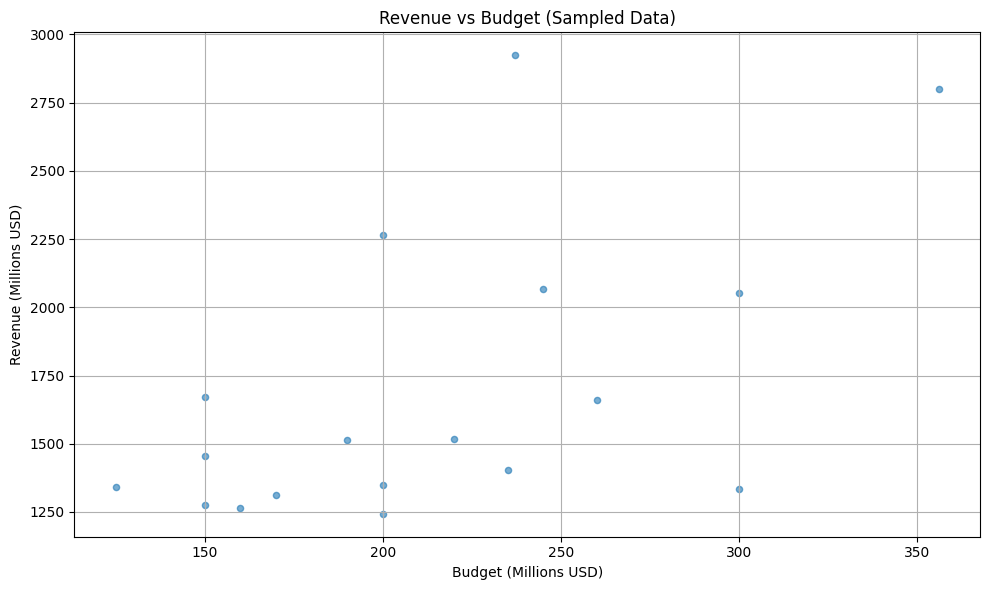

2026-01-16 16:15:00,574 - INFO - visualizations - Revenue vs Budget plot completed


In [49]:
viz.plot_revenue_vs_budget(df)

### 1. General Trend

* There is a **positive correlation** between budget and revenue. Movies with higher budgets generally earn more revenue, which aligns with expectations for big blockbuster films.
* However, the correlation is **not perfect**, indicating that high budget does not always guarantee top revenue.

### 2. Outliers

* A few movies stand out with **extremely high revenue** compared to others (top-right cluster). These are likely major franchise films like *Avengers: Endgame* or *Avatar*.
* Some movies with **high budgets but relatively lower revenue** indicate that a large investment doesn’t always translate to massive box office success.

### 3. Mid-range Budgets

* Movies with **budgets around 150–250M USD** show a wide variation in revenue (from 1250M to 2900M USD).
* This suggests that factors beyond budget like **franchise strength, marketing, cast, and reviews** play a major role in revenue generation.

### 4. Low-budget Films

* There are no extreme low-budget movies on this chart. Likely, the dataset focuses on **big studio releases**, so small indie films aren’t represented here.

---

**Key Insight:**
Budget increases potential revenue, but the **success of a movie depends heavily on other factors** such as franchise popularity, fan base, marketing, and critical reception. Investing more increases the ceiling but doesn’t guarantee a blockbuster hit.

### 2. ROI Distribution by Genre

2026-01-16 16:15:00,618 - INFO - visualizations - Preparing ROI by Genre bar plot


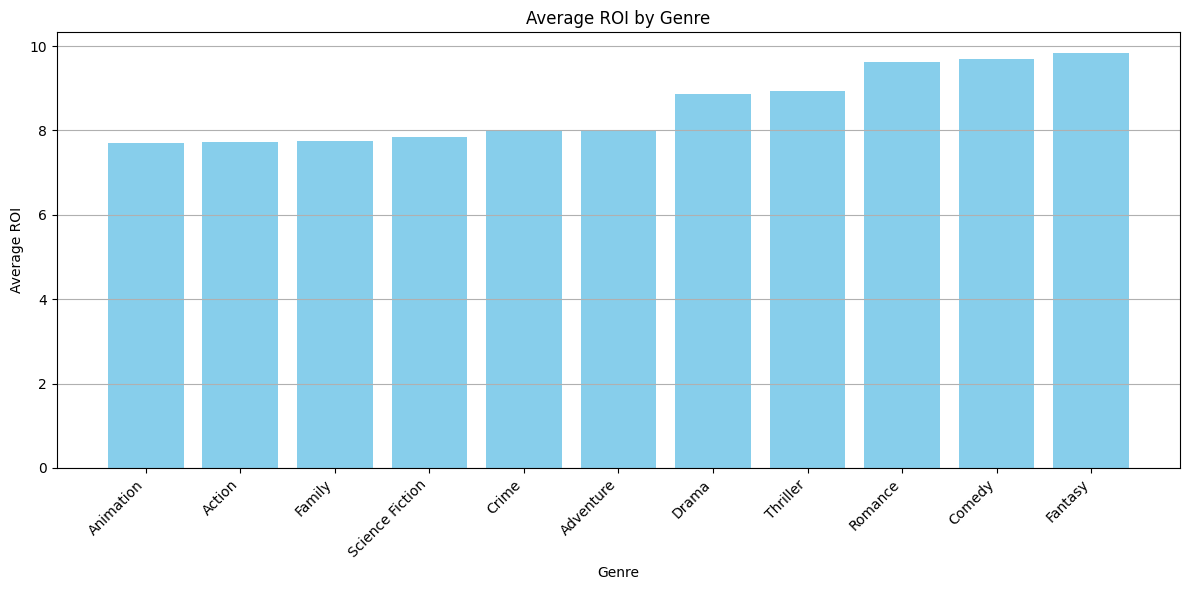

2026-01-16 16:15:01,923 - INFO - visualizations - ROI by Genre plot completed


In [50]:
viz.plot_roi_by_genre(df)

### **1. ROI is fairly consistent across most genres**

* Most genres hover around an average ROI of **7–10**.
* Genres like **Drama, Thriller, Romance, Comedy, Fantasy** are slightly higher (~9–10).
* Genres like **Animation, Action, Family, Sci-Fi, Crime, Adventure** are slightly lower (~7–8).

This suggests that **all genres can be profitable**, but some genres have slightly better ROI on average.

---

### **2. Highest ROI genres**

* **Romance, Comedy, Fantasy** appear to have the **highest average ROI (~9.8–10)**.
* These genres might be **lower-budget films with high audience appeal**, hence giving a better ROI.

---

### **3. Lowest ROI genres**

* **Animation, Action, Family, Sci-Fi, Crime, Adventure** are slightly lower.
* Likely reasons: **higher production costs** (big budgets) can reduce ROI even if box office revenue is high.

---

### **4. Implications for decision-making**

* If selecting movies for investment or focus in a portfolio:

  * **Romance, Comedy, Fantasy** might be safer in terms of ROI.
  * **Action, Sci-Fi, Adventure** may require **larger budgets**, so ROI is more sensitive to box office performance.


### 3. Popularity vs Rating

2026-01-16 16:15:02,003 - INFO - visualizations - Preparing Popularity vs Rating scatter plot (sampling 10000 rows)


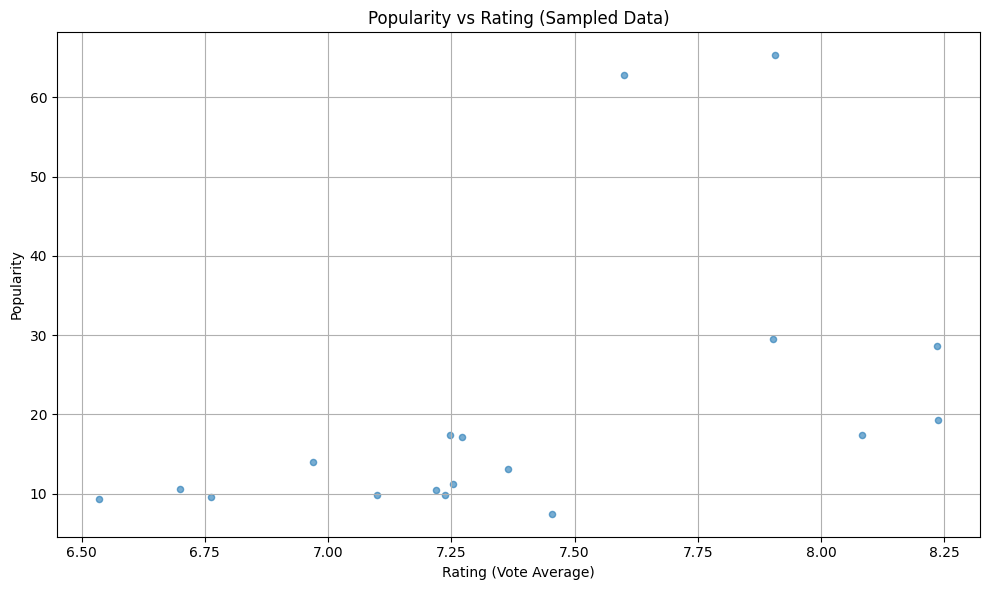

2026-01-16 16:15:02,676 - INFO - visualizations - Popularity vs Rating plot completed


In [51]:
viz.plot_popularity_vs_rating(df)

1. **Weak correlation between popularity and rating**:

   * Most points cluster around ratings 6.5–7.5 and popularity 5–10, suggesting that a majority of movies have moderate ratings and low popularity.
   * There are a few outliers with very high popularity (20–40) that do not necessarily have the highest ratings, indicating that popularity is not solely determined by rating.

2. **High popularity does not always equal high rating**:

   * For example, there’s a movie with a rating around 7.8 but a popularity above 40. This suggests that factors like marketing, franchise, or star cast may drive popularity more than critical rating.

3. ** Some highly-rated movies are not the most popular**:

   * Movies with ratings above 8 have popularity values around 15–20, which is lower than the extreme popularity outliers. This indicates that some highly-rated movies may appeal to a niche audience rather than the mass public.

4. **Clustering of data**:

   * The majority of movies are in the rating range of 6.5–7.5 and popularity 5–10, which likely represents standard mainstream movies with moderate reception.

5. **Outliers**:

   * A few movies have either very high popularity or high ratings that stand out from the general trend. These are likely blockbuster hits or critically acclaimed movies that could be analyzed separately for patterns.

**Overall insight:** Popularity and rating are **not strongly correlated**. High ratings don’t always guarantee high popularity, and highly popular movies aren’t necessarily the highest rated. Marketing, franchise effects, or other factors likely influence popularity more than just ratings.


### 4. Yearly Box Office Trend

2026-01-16 16:15:02,729 - INFO - visualizations - Preparing Yearly Box Office Performance plot


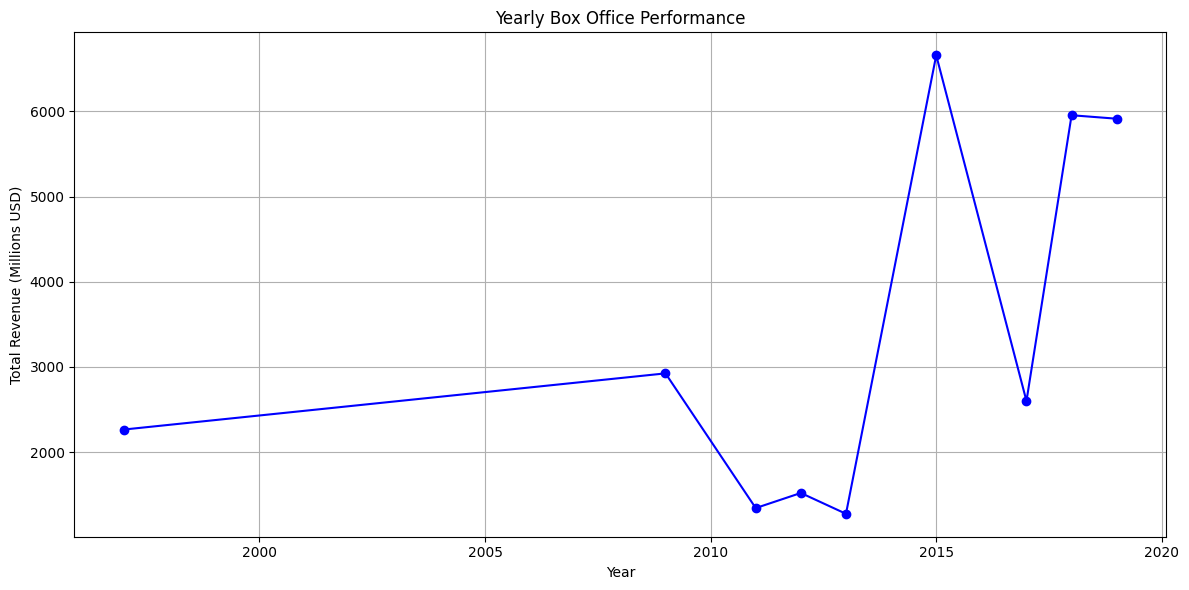

2026-01-16 16:15:03,702 - INFO - visualizations - Yearly Box Office plot completed


In [52]:
viz.plot_yearly_box_office(df)

### **Key Insights from the Yearly Box Office Trend**

1. **Steady Growth Early On (1998–2008)**

   * The box office revenue shows a gradual and consistent increase during this period.
   * This suggests stable industry performance with no major disruptions.

2. **Sharp Decline Around 2010–2012**

   * There's a sudden drop after 2009, reaching the lowest point around 2012–2013.
   * This could indicate fewer blockbuster releases, economic factors, or changes in audience behavior.

3. **Major Spike in 2014 t0 2015**

   * The chart shows a dramatic jump around 2015, reaching the highest revenue in the dataset.
   * This suggests a highly successful year—possibly due to major franchise releases or broader audience engagement.

4. **Fluctuation After Peak (2015–2019)**

   * After the 2015 spike, revenue drops again but then rises back toward 2019.
   * This indicates an unstable yet recovering trend during these years.

### **Insight**

This analysis shows that the film industry experienced stable growth until 2008, followed by a significant downturn between 2010 and 2013. However, the industry rebounded strongly in 2015 with a major spike in revenue. Although there were fluctuations afterwards, the general trend suggests a partial recovery heading toward 2019.


### 5. Franchise vs Standalone Comparison

2026-01-16 16:15:03,765 - INFO - visualizations - Preparing Franchise vs Standalone Success plot


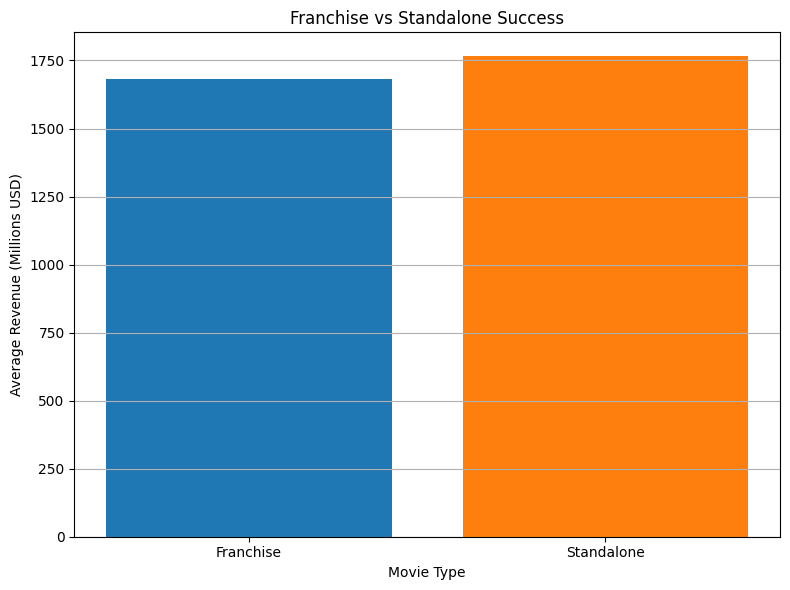

2026-01-16 16:15:04,490 - INFO - visualizations - Franchise vs Standalone plot completed


In [53]:
viz.plot_franchise_vs_standalone(df)

### Insights: Franchise vs Standalone Movie Success

1. **Standalone movies slightly outperform franchises**

   * The chart shows that standalone films have a **higher average revenue** (around 1.78 billion USD) compared to franchise movies (about 1.69 billion USD).

2. **Difference is small but noticeable**

   * While both categories perform strongly, standalone movies hold a **small revenue advantage**, suggesting that unique, non-franchise stories can generate significant box office success.

3. **Franchises are still consistently high performers**

   * Even though standalone films lead, franchises still maintain very high average revenues, showing their **strong audience loyalty and market reliability**.

---

### **Insight**

The comparison indicates that standalone movies generate slightly higher average revenue than franchise films. However, both categories perform well overall, suggesting that while franchises benefit from established fan bases, standalone titles can achieve exceptional box office success through originality and strong storytelling.



# Conclusion

The TMDb movie data analysis project demonstrates the ability to extract, clean, and analyze complex datasets using Python and Pandas, while leveraging APIs for real-world data. The workflow highlights the importance of thorough data preprocessing, including handling missing values, transforming nested data structures, and filtering for relevant records, to ensure reliable insights. Through exploratory and advanced analyses, patterns in movie performance emerge, such as the influence of genres, franchises, directors, and budgets on revenue, popularity, and ROI. Additionally, the project reinforces how KPIs and visualizations can effectively communicate trends and support data-driven conclusions. Overall, the project provides a comprehensive understanding of both technical data manipulation skills and the practical considerations of evaluating success in the film industry.